In [25]:
savepath = '/Users/anyak/Documents/Projects/NeuroAI2024/neuroai_learning_rules/weight_perturb_results'

In [28]:
#WeightPerturb V2:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

class WeightPerturbMLP:
    def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
        self.W_h = np.random.normal(0, sigma, (input_size, hidden_size))
        self.W_y = np.random.normal(0, sigma, (hidden_size, output_size))
        self.sigma = sigma

    def forward(self, X):
        self.h = np.maximum(0, X @ self.W_h)  # ReLU activation
        self.y = self.h @ self.W_y
        return self.y

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def loss(self, X, targets):
        outputs = self.softmax(self.forward(X))
        return -np.mean(np.sum(targets * np.log(outputs + 1e-10), axis=1))

    def weight_perturbation(self, X, targets, eta, K):
        base_loss = self.loss(X, targets)

        W_h_update = np.zeros_like(self.W_h)
        W_y_update = np.zeros_like(self.W_y)

        for _ in range(K):
            Psi_h = np.random.normal(0, self.sigma, self.W_h.shape)
            Psi_y = np.random.normal(0, self.sigma, self.W_y.shape)

            W_h_perturbed = self.W_h + Psi_h
            W_y_perturbed = self.W_y + Psi_y

            self.W_h, self.W_y = W_h_perturbed, W_y_perturbed
            perturbed_loss = self.loss(X, targets)
            self.W_h, self.W_y = W_h_perturbed - Psi_h, W_y_perturbed - Psi_y

            delta_loss = perturbed_loss - base_loss

            W_h_update += (delta_loss * Psi_h) / (self.sigma**2)
            W_y_update += (delta_loss * Psi_y) / (self.sigma**2)

        W_h_update *= -eta / K
        W_y_update *= -eta / K

        return W_h_update, W_y_update

# Load and preprocess MNIST data
print("Loading MNIST data...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Initialize model
model = WeightPerturbMLP(784, 500, 10, sigma=0.01)

# Training parameters
epochs = 10
batch_size = 64
eta = 0.001  # Reduced learning rate
K = 10  # number of perturbation samples

# Training loop
losses = []
test_accuracies = []

print("Starting training...")
for epoch in tqdm(range(epochs)):
    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train_onehot[i:i+batch_size]

        W_h_update, W_y_update = model.weight_perturbation(batch_X, batch_y, eta, K)

        model.W_h += W_h_update
        model.W_y += W_y_update

        batch_loss = model.loss(batch_X, batch_y)
        epoch_losses.append(batch_loss)

        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {batch_loss:.4f}")

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)

    # Evaluate on test set
    y_pred = model.softmax(model.forward(X_test))
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Plot learning curve after each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.savefig(savepath+f'/epoch_{epoch+1}.png')  # Save the figure
    plt.show()

print("Training completed. Generating final visualizations...")

# Final Confusion Matrix
y_pred = model.softmax(model.forward(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(savepath+'/confusion_matrix.png')  # Save the confusion matrix
plt.show()

print("All done!")

Loading MNIST data...


KeyboardInterrupt: 

# WP version 3
**Increased Epochs:** Training for more epochs to give the model more time to learn.
**Increased K:** More perturbation samples for better gradient estimation.
**Dropout:** Added dropout in the hidden layer during training for regularization.
**Batch Size:** Keeping batch size at 64.
**Evaluation:** Evaluating on the test set without dropout.

Loading MNIST data...


/Users/anyak/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Starting training...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Batch 0, Loss: 2.3020


Epoch 1/15, Batch 10, Loss: 2.3003


Epoch 1/15, Batch 20, Loss: 2.3017


Epoch 1/15, Batch 30, Loss: 2.2990


Epoch 1/15, Batch 40, Loss: 2.2992


Epoch 1/15, Batch 50, Loss: 2.3003


Epoch 1/15, Batch 60, Loss: 2.2982


Epoch 1/15, Batch 70, Loss: 2.3008


Epoch 1/15, Batch 80, Loss: 2.3016


Epoch 1/15, Batch 90, Loss: 2.2984


Epoch 1/15, Batch 100, Loss: 2.2979


Epoch 1/15, Batch 110, Loss: 2.2988


Epoch 1/15, Batch 120, Loss: 2.3015


Epoch 1/15, Batch 130, Loss: 2.3006


Epoch 1/15, Batch 140, Loss: 2.2969



 13%|█▎        | 152/1167 [00:39<04:14,  3.99it/s]

Epoch 1/15, Batch 150, Loss: 2.2969


Epoch 1/15, Batch 160, Loss: 2.2987


Epoch 1/15, Batch 170, Loss: 2.2951


Epoch 1/15, Batch 180, Loss: 2.2996


Epoch 1/15, Batch 190, Loss: 2.3026


Epoch 1/15, Batch 200, Loss: 2.2937


Epoch 1/15, Batch 210, Loss: 2.2975



 19%|█▉        | 222/1167 [00:54<03:21,  4.69it/s]

Epoch 1/15, Batch 220, Loss: 2.2972


Epoch 1/15, Batch 230, Loss: 2.2944


Epoch 1/15, Batch 240, Loss: 2.2914


Epoch 1/15, Batch 250, Loss: 2.2957


Epoch 1/15, Batch 260, Loss: 2.2950


Epoch 1/15, Batch 270, Loss: 2.2924


Epoch 1/15, Batch 280, Loss: 2.2968


Epoch 1/15, Batch 290, Loss: 2.2905


Epoch 1/15, Batch 300, Loss: 2.2937


Epoch 1/15, Batch 310, Loss: 2.2953


Epoch 1/15, Batch 320, Loss: 2.2974


Epoch 1/15, Batch 330, Loss: 2.2885


Epoch 1/15, Batch 340, Loss: 2.2964


Epoch 1/15, Batch 350, Loss: 2.2904


Epoch 1/15, Batch 360, Loss: 2.2893


Epoch 1/15, Batch 370, Loss: 2.2877


Epoch 1/15, Batch 380, Loss: 2.2859


Epoch 1/15, Batch 390, Loss: 2.2895


Epoch 1/15, Batch 400, Loss: 2.2872


Epoch 1/15, Batch 410, Loss: 2.2923


Epoch 1/15, Batch 420, Loss: 2.2902


Epoch 1/15, Batch 430, Loss: 2.2879


Epoch 1/15, Batch 440, Loss: 2.2870


Epoch 1/15, Batch 450, Loss: 2.2865


Epoch 1/15, Batch 460, Loss: 2.2915


Epoch 1/15, Batch 470, Loss: 2.2871


Epoch 1/15, Batch 480, Loss: 2.2850


Epoch 1/15, Batch 490, Loss: 2.2890


Epoch 1/15, Batch 500, Loss: 2.2848


Epoch 1/15, Batch 510, Loss: 2.2835


Epoch 1/15, Batch 520, Loss: 2.2851


 45%|████▍     | 522/1167 [01:40<01:54,  5.64it/s]

Epoch 1/15, Batch 530, Loss: 2.2859


Epoch 1/15, Batch 540, Loss: 2.2865


Epoch 1/15, Batch 550, Loss: 2.2827


Epoch 1/15, Batch 560, Loss: 2.2885


Epoch 1/15, Batch 570, Loss: 2.2833


Epoch 1/15, Batch 580, Loss: 2.2848


Epoch 1/15, Batch 590, Loss: 2.2824


 51%|█████     | 592/1167 [01:52<01:44,  5.52it/s]

Epoch 1/15, Batch 600, Loss: 2.2849


Epoch 1/15, Batch 610, Loss: 2.2843


Epoch 1/15, Batch 620, Loss: 2.2816


Epoch 1/15, Batch 630, Loss: 2.2797


Epoch 1/15, Batch 640, Loss: 2.2870


Epoch 1/15, Batch 650, Loss: 2.2840


Epoch 1/15, Batch 660, Loss: 2.2815


Epoch 1/15, Batch 670, Loss: 2.2872


Epoch 1/15, Batch 680, Loss: 2.2808


Epoch 1/15, Batch 690, Loss: 2.2843


Epoch 1/15, Batch 700, Loss: 2.2798


Epoch 1/15, Batch 710, Loss: 2.2830


Epoch 1/15, Batch 720, Loss: 2.2801


Epoch 1/15, Batch 730, Loss: 2.2793


Epoch 1/15, Batch 740, Loss: 2.2769


Epoch 1/15, Batch 750, Loss: 2.2820


Epoch 1/15, Batch 760, Loss: 2.2796


Epoch 1/15, Batch 770, Loss: 2.2751



 67%|██████▋   | 782/1167 [02:29<01:15,  5.08it/s]

Epoch 1/15, Batch 780, Loss: 2.2818


Epoch 1/15, Batch 790, Loss: 2.2766


Epoch 1/15, Batch 800, Loss: 2.2810


Epoch 1/15, Batch 810, Loss: 2.2749


 70%|██████▉   | 812/1167 [02:34<01:03,  5.59it/s]

Epoch 1/15, Batch 820, Loss: 2.2743


Epoch 1/15, Batch 830, Loss: 2.2796


Epoch 1/15, Batch 840, Loss: 2.2734


Epoch 1/15, Batch 850, Loss: 2.2722


Epoch 1/15, Batch 860, Loss: 2.2730


Epoch 1/15, Batch 870, Loss: 2.2711


Epoch 1/15, Batch 880, Loss: 2.2836


Epoch 1/15, Batch 890, Loss: 2.2722


Epoch 1/15, Batch 900, Loss: 2.2743


Epoch 1/15, Batch 910, Loss: 2.2687


Epoch 1/15, Batch 920, Loss: 2.2743


Epoch 1/15, Batch 930, Loss: 2.2717


Epoch 1/15, Batch 940, Loss: 2.2589


Epoch 1/15, Batch 950, Loss: 2.2642


Epoch 1/15, Batch 960, Loss: 2.2797


Epoch 1/15, Batch 970, Loss: 2.2755


Epoch 1/15, Batch 980, Loss: 2.2788


Epoch 1/15, Batch 990, Loss: 2.2707


Epoch 1/15, Batch 1000, Loss: 2.2604


Epoch 1/15, Batch 1010, Loss: 2.2667


Epoch 1/15, Batch 1020, Loss: 2.2761


Epoch 1/15, Batch 1030, Loss: 2.2684


Epoch 1/15, Batch 1040, Loss: 2.2656


Epoch 1/15, Batch 1050, Loss: 2.2630


Epoch 1/15, Batch 1060, Loss: 2.2711


Epoch 1/15, Batch 1070, Loss: 2.2682


Epoch 1/15, Batch 1080, Loss: 2.2605


Epoch 1/15, Batch 1090, Loss: 2.2725


Epoch 1/15, Batch 1100, Loss: 2.2646


Epoch 1/15, Batch 1110, Loss: 2.2648


Epoch 1/15, Batch 1120, Loss: 2.2624


Epoch 1/15, Batch 1130, Loss: 2.2632


Epoch 1/15, Batch 1140, Loss: 2.2528


Epoch 1/15, Batch 1150, Loss: 2.2601


Epoch 1/15, Batch 1160, Loss: 2.2692


100%|██████████| 1167/1167 [03:30<00:00,  5.56it/s]


Epoch 1/15 completed. Avg Loss: 2.2835, Test Accuracy: 0.4889


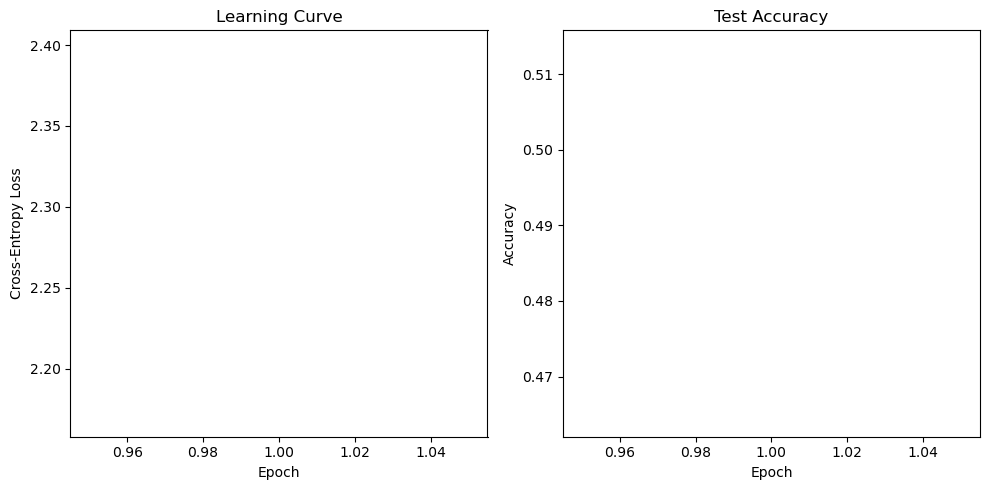

  7%|▋         | 1/15 [03:30<49:06, 210.50s/it]

Epoch 2/15, Batch 0, Loss: 2.2675


Epoch 2/15, Batch 10, Loss: 2.2462


Epoch 2/15, Batch 20, Loss: 2.2589


Epoch 2/15, Batch 30, Loss: 2.2647


Epoch 2/15, Batch 40, Loss: 2.2657


Epoch 2/15, Batch 50, Loss: 2.2539


Epoch 2/15, Batch 60, Loss: 2.2518


Epoch 2/15, Batch 70, Loss: 2.2581


Epoch 2/15, Batch 80, Loss: 2.2615


Epoch 2/15, Batch 90, Loss: 2.2694


Epoch 2/15, Batch 100, Loss: 2.2580


Epoch 2/15, Batch 110, Loss: 2.2461


Epoch 2/15, Batch 120, Loss: 2.2608


Epoch 2/15, Batch 130, Loss: 2.2602


Epoch 2/15, Batch 140, Loss: 2.2562


Epoch 2/15, Batch 150, Loss: 2.2495


Epoch 2/15, Batch 160, Loss: 2.2653


Epoch 2/15, Batch 170, Loss: 2.2641


Epoch 2/15, Batch 180, Loss: 2.2648


Epoch 2/15, Batch 190, Loss: 2.2664


Epoch 2/15, Batch 200, Loss: 2.2486


Epoch 2/15, Batch 210, Loss: 2.2541


Epoch 2/15, Batch 220, Loss: 2.2497


Epoch 2/15, Batch 230, Loss: 2.2549


Epoch 2/15, Batch 240, Loss: 2.2559


Epoch 2/15, Batch 250, Loss: 2.2577


Epoch 2/15, Batch 260, Loss: 2.2534


Epoch 2/15, Batch 270, Loss: 2.2334


Epoch 2/15, Batch 280, Loss: 2.2511


Epoch 2/15, Batch 290, Loss: 2.2487


Epoch 2/15, Batch 300, Loss: 2.2474


Epoch 2/15, Batch 310, Loss: 2.2500


Epoch 2/15, Batch 320, Loss: 2.2449


Epoch 2/15, Batch 330, Loss: 2.2338


Epoch 2/15, Batch 340, Loss: 2.2561


Epoch 2/15, Batch 350, Loss: 2.2342


Epoch 2/15, Batch 360, Loss: 2.2393


Epoch 2/15, Batch 370, Loss: 2.2358


Epoch 2/15, Batch 380, Loss: 2.2492


Epoch 2/15, Batch 390, Loss: 2.2458


Epoch 2/15, Batch 400, Loss: 2.2301


Epoch 2/15, Batch 410, Loss: 2.2532


Epoch 2/15, Batch 420, Loss: 2.2457


Epoch 2/15, Batch 430, Loss: 2.2408


Epoch 2/15, Batch 440, Loss: 2.2415


Epoch 2/15, Batch 450, Loss: 2.2307


Epoch 2/15, Batch 460, Loss: 2.2477


Epoch 2/15, Batch 470, Loss: 2.2372


Epoch 2/15, Batch 480, Loss: 2.2267


Epoch 2/15, Batch 490, Loss: 2.2375


Epoch 2/15, Batch 500, Loss: 2.2297


Epoch 2/15, Batch 510, Loss: 2.2271


Epoch 2/15, Batch 520, Loss: 2.2284


Epoch 2/15, Batch 530, Loss: 2.2304


Epoch 2/15, Batch 540, Loss: 2.2355


Epoch 2/15, Batch 550, Loss: 2.2325


Epoch 2/15, Batch 560, Loss: 2.2438


Epoch 2/15, Batch 570, Loss: 2.2338


Epoch 2/15, Batch 580, Loss: 2.2273


Epoch 2/15, Batch 590, Loss: 2.2271


Epoch 2/15, Batch 600, Loss: 2.2364


Epoch 2/15, Batch 610, Loss: 2.2270


Epoch 2/15, Batch 620, Loss: 2.2213


Epoch 2/15, Batch 630, Loss: 2.2171


Epoch 2/15, Batch 640, Loss: 2.2367


Epoch 2/15, Batch 650, Loss: 2.2251


Epoch 2/15, Batch 660, Loss: 2.2214


Epoch 2/15, Batch 670, Loss: 2.2353


Epoch 2/15, Batch 680, Loss: 2.2211


Epoch 2/15, Batch 690, Loss: 2.2456


Epoch 2/15, Batch 700, Loss: 2.2182


Epoch 2/15, Batch 710, Loss: 2.2326


Epoch 2/15, Batch 720, Loss: 2.2222


Epoch 2/15, Batch 730, Loss: 2.2184


Epoch 2/15, Batch 740, Loss: 2.2183


Epoch 2/15, Batch 750, Loss: 2.2279


Epoch 2/15, Batch 760, Loss: 2.2213


Epoch 2/15, Batch 770, Loss: 2.2160


Epoch 2/15, Batch 780, Loss: 2.2252


Epoch 2/15, Batch 790, Loss: 2.2119


Epoch 2/15, Batch 800, Loss: 2.2258


Epoch 2/15, Batch 810, Loss: 2.2081


Epoch 2/15, Batch 820, Loss: 2.2052


Epoch 2/15, Batch 830, Loss: 2.2209


Epoch 2/15, Batch 840, Loss: 2.2081


Epoch 2/15, Batch 850, Loss: 2.2084


Epoch 2/15, Batch 860, Loss: 2.2142


Epoch 2/15, Batch 870, Loss: 2.2013


Epoch 2/15, Batch 880, Loss: 2.2315


Epoch 2/15, Batch 890, Loss: 2.2064


Epoch 2/15, Batch 900, Loss: 2.2130


Epoch 2/15, Batch 910, Loss: 2.2002


Epoch 2/15, Batch 920, Loss: 2.2140


Epoch 2/15, Batch 930, Loss: 2.2035


Epoch 2/15, Batch 940, Loss: 2.1736


Epoch 2/15, Batch 950, Loss: 2.1900


Epoch 2/15, Batch 960, Loss: 2.2272


Epoch 2/15, Batch 970, Loss: 2.2236


Epoch 2/15, Batch 980, Loss: 2.2320


Epoch 2/15, Batch 990, Loss: 2.2044


Epoch 2/15, Batch 1000, Loss: 2.1840


Epoch 2/15, Batch 1010, Loss: 2.1977


Epoch 2/15, Batch 1020, Loss: 2.2217


Epoch 2/15, Batch 1030, Loss: 2.2047


Epoch 2/15, Batch 1040, Loss: 2.2011


Epoch 2/15, Batch 1050, Loss: 2.1845


Epoch 2/15, Batch 1060, Loss: 2.2158


Epoch 2/15, Batch 1070, Loss: 2.2029


Epoch 2/15, Batch 1080, Loss: 2.1836


Epoch 2/15, Batch 1090, Loss: 2.2127


Epoch 2/15, Batch 1100, Loss: 2.1954


Epoch 2/15, Batch 1110, Loss: 2.2035


Epoch 2/15, Batch 1120, Loss: 2.1858


Epoch 2/15, Batch 1130, Loss: 2.1871


Epoch 2/15, Batch 1140, Loss: 2.1621


Epoch 2/15, Batch 1150, Loss: 2.1834


Epoch 2/15, Batch 1160, Loss: 2.2080


100%|██████████| 1167/1167 [02:54<00:00,  6.68it/s]


Epoch 2/15 completed. Avg Loss: 2.2298, Test Accuracy: 0.5601


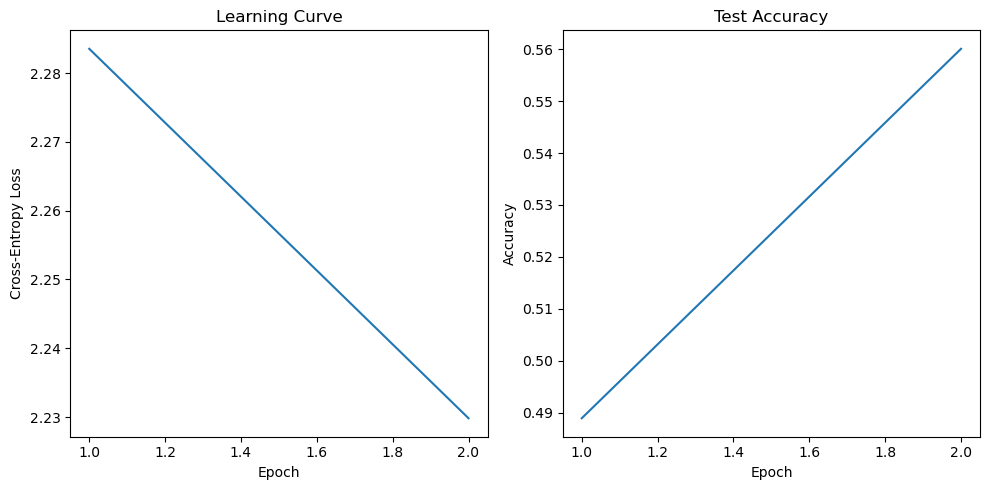

 13%|█▎        | 2/15 [06:25<41:05, 189.66s/it]

Epoch 3/15, Batch 0, Loss: 2.2040


Epoch 3/15, Batch 10, Loss: 2.1467


Epoch 3/15, Batch 20, Loss: 2.1829


Epoch 3/15, Batch 30, Loss: 2.2023


Epoch 3/15, Batch 40, Loss: 2.1985


Epoch 3/15, Batch 50, Loss: 2.1700


Epoch 3/15, Batch 60, Loss: 2.1728


Epoch 3/15, Batch 70, Loss: 2.1814


Epoch 3/15, Batch 80, Loss: 2.1912


Epoch 3/15, Batch 90, Loss: 2.2088


Epoch 3/15, Batch 100, Loss: 2.1831


Epoch 3/15, Batch 110, Loss: 2.1501


Epoch 3/15, Batch 120, Loss: 2.1878


Epoch 3/15, Batch 130, Loss: 2.1827


Epoch 3/15, Batch 140, Loss: 2.1804


Epoch 3/15, Batch 150, Loss: 2.1600


Epoch 3/15, Batch 160, Loss: 2.2009


Epoch 3/15, Batch 170, Loss: 2.2063


Epoch 3/15, Batch 180, Loss: 2.1979


Epoch 3/15, Batch 190, Loss: 2.1972


Epoch 3/15, Batch 200, Loss: 2.1649


Epoch 3/15, Batch 210, Loss: 2.1692


Epoch 3/15, Batch 220, Loss: 2.1607


Epoch 3/15, Batch 230, Loss: 2.1831


Epoch 3/15, Batch 240, Loss: 2.1786


Epoch 3/15, Batch 250, Loss: 2.1859


Epoch 3/15, Batch 260, Loss: 2.1780


Epoch 3/15, Batch 270, Loss: 2.1288


Epoch 3/15, Batch 280, Loss: 2.1761


Epoch 3/15, Batch 290, Loss: 2.1632


Epoch 3/15, Batch 300, Loss: 2.1631


Epoch 3/15, Batch 310, Loss: 2.1636


Epoch 3/15, Batch 320, Loss: 2.1507


Epoch 3/15, Batch 330, Loss: 2.1286


Epoch 3/15, Batch 340, Loss: 2.1808


Epoch 3/15, Batch 350, Loss: 2.1275


Epoch 3/15, Batch 360, Loss: 2.1431


Epoch 3/15, Batch 370, Loss: 2.1355


Epoch 3/15, Batch 380, Loss: 2.1751


Epoch 3/15, Batch 390, Loss: 2.1684


Epoch 3/15, Batch 400, Loss: 2.1245


Epoch 3/15, Batch 410, Loss: 2.1778


Epoch 3/15, Batch 420, Loss: 2.1620


Epoch 3/15, Batch 430, Loss: 2.1483


Epoch 3/15, Batch 440, Loss: 2.1527


Epoch 3/15, Batch 450, Loss: 2.1247


Epoch 3/15, Batch 460, Loss: 2.1681


Epoch 3/15, Batch 470, Loss: 2.1472


Epoch 3/15, Batch 480, Loss: 2.1113


Epoch 3/15, Batch 490, Loss: 2.1417


Epoch 3/15, Batch 500, Loss: 2.1293


Epoch 3/15, Batch 510, Loss: 2.1297


Epoch 3/15, Batch 520, Loss: 2.1241


Epoch 3/15, Batch 530, Loss: 2.1281


Epoch 3/15, Batch 540, Loss: 2.1457


Epoch 3/15, Batch 550, Loss: 2.1434


Epoch 3/15, Batch 560, Loss: 2.1612


Epoch 3/15, Batch 570, Loss: 2.1418


Epoch 3/15, Batch 580, Loss: 2.1332


Epoch 3/15, Batch 590, Loss: 2.1204


Epoch 3/15, Batch 600, Loss: 2.1506


Epoch 3/15, Batch 610, Loss: 2.1222


Epoch 3/15, Batch 620, Loss: 2.1113


Epoch 3/15, Batch 630, Loss: 2.0975


Epoch 3/15, Batch 640, Loss: 2.1485


Epoch 3/15, Batch 650, Loss: 2.1205


Epoch 3/15, Batch 660, Loss: 2.1128


Epoch 3/15, Batch 670, Loss: 2.1277


Epoch 3/15, Batch 680, Loss: 2.1134


Epoch 3/15, Batch 690, Loss: 2.1735


Epoch 3/15, Batch 700, Loss: 2.1181


Epoch 3/15, Batch 710, Loss: 2.1301


Epoch 3/15, Batch 720, Loss: 2.1158


Epoch 3/15, Batch 730, Loss: 2.1082


Epoch 3/15, Batch 740, Loss: 2.1220


Epoch 3/15, Batch 750, Loss: 2.1321


Epoch 3/15, Batch 760, Loss: 2.1082


Epoch 3/15, Batch 770, Loss: 2.1056


Epoch 3/15, Batch 780, Loss: 2.1230


Epoch 3/15, Batch 790, Loss: 2.1048


Epoch 3/15, Batch 800, Loss: 2.1187


Epoch 3/15, Batch 810, Loss: 2.0943


Epoch 3/15, Batch 820, Loss: 2.0750


Epoch 3/15, Batch 830, Loss: 2.1180


Epoch 3/15, Batch 840, Loss: 2.0846


Epoch 3/15, Batch 850, Loss: 2.0946


Epoch 3/15, Batch 860, Loss: 2.1090


Epoch 3/15, Batch 870, Loss: 2.0782


Epoch 3/15, Batch 880, Loss: 2.1345


Epoch 3/15, Batch 890, Loss: 2.0813


Epoch 3/15, Batch 900, Loss: 2.0954


Epoch 3/15, Batch 910, Loss: 2.0720


Epoch 3/15, Batch 920, Loss: 2.0997


Epoch 3/15, Batch 930, Loss: 2.0769


Epoch 3/15, Batch 940, Loss: 2.0130


Epoch 3/15, Batch 950, Loss: 2.0529


Epoch 3/15, Batch 960, Loss: 2.1223


Epoch 3/15, Batch 970, Loss: 2.1265


Epoch 3/15, Batch 980, Loss: 2.1413


Epoch 3/15, Batch 990, Loss: 2.0619


Epoch 3/15, Batch 1000, Loss: 2.0346


Epoch 3/15, Batch 1010, Loss: 2.0694


Epoch 3/15, Batch 1020, Loss: 2.0965


Epoch 3/15, Batch 1030, Loss: 2.0764


Epoch 3/15, Batch 1040, Loss: 2.0750


Epoch 3/15, Batch 1050, Loss: 2.0344


Epoch 3/15, Batch 1060, Loss: 2.1012


Epoch 3/15, Batch 1070, Loss: 2.0879


Epoch 3/15, Batch 1080, Loss: 2.0317


Epoch 3/15, Batch 1090, Loss: 2.0940


Epoch 3/15, Batch 1100, Loss: 2.0643


Epoch 3/15, Batch 1110, Loss: 2.0757


Epoch 3/15, Batch 1120, Loss: 2.0406


Epoch 3/15, Batch 1130, Loss: 2.0316


 97%|█████████▋| 1132/1167 [02:52<00:06,  5.06it/s]

Epoch 3/15, Batch 1140, Loss: 1.9925


Epoch 3/15, Batch 1150, Loss: 2.0266


Epoch 3/15, Batch 1160, Loss: 2.0752


100%|██████████| 1167/1167 [02:58<00:00,  6.55it/s]


Epoch 3/15 completed. Avg Loss: 2.1288, Test Accuracy: 0.6364


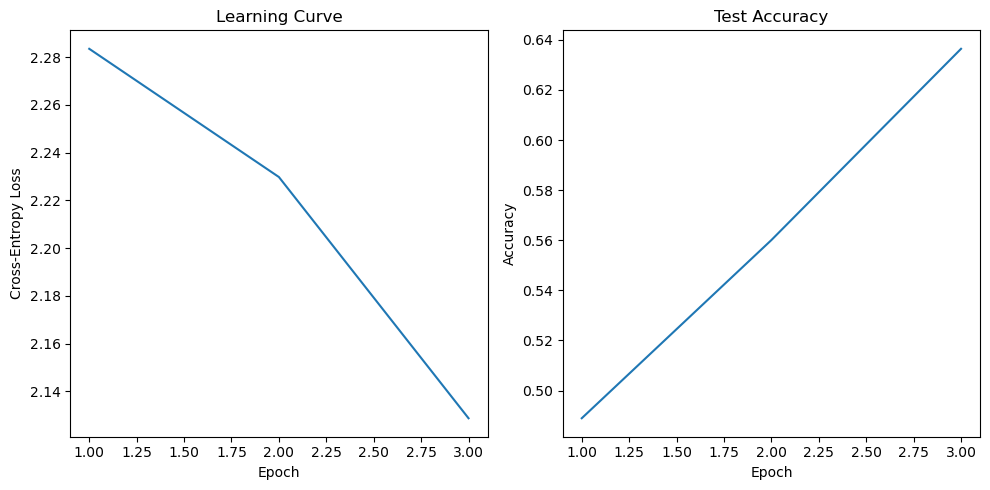

 20%|██        | 3/15 [09:24<36:55, 184.66s/it]

Epoch 4/15, Batch 0, Loss: 2.0845


Epoch 4/15, Batch 10, Loss: 1.9640


Epoch 4/15, Batch 20, Loss: 2.0466


Epoch 4/15, Batch 30, Loss: 2.0725


Epoch 4/15, Batch 40, Loss: 2.0688


Epoch 4/15, Batch 50, Loss: 2.0084


Epoch 4/15, Batch 60, Loss: 2.0145


Epoch 4/15, Batch 70, Loss: 2.0376


Epoch 4/15, Batch 80, Loss: 2.0607


Epoch 4/15, Batch 90, Loss: 2.0901


Epoch 4/15, Batch 100, Loss: 2.0461


Epoch 4/15, Batch 110, Loss: 1.9757


Epoch 4/15, Batch 120, Loss: 2.0444


Epoch 4/15, Batch 130, Loss: 2.0258


Epoch 4/15, Batch 140, Loss: 2.0389


Epoch 4/15, Batch 150, Loss: 1.9881


Epoch 4/15, Batch 160, Loss: 2.0772


Epoch 4/15, Batch 170, Loss: 2.0850


Epoch 4/15, Batch 180, Loss: 2.0632


Epoch 4/15, Batch 190, Loss: 2.0461


Epoch 4/15, Batch 200, Loss: 2.0021


Epoch 4/15, Batch 210, Loss: 2.0085


Epoch 4/15, Batch 220, Loss: 1.9926


Epoch 4/15, Batch 230, Loss: 2.0419


Epoch 4/15, Batch 240, Loss: 2.0334


Epoch 4/15, Batch 250, Loss: 2.0544


Epoch 4/15, Batch 260, Loss: 2.0365


Epoch 4/15, Batch 270, Loss: 1.9226


Epoch 4/15, Batch 280, Loss: 2.0132


Epoch 4/15, Batch 290, Loss: 2.0024


Epoch 4/15, Batch 300, Loss: 1.9918


Epoch 4/15, Batch 310, Loss: 1.9999


Epoch 4/15, Batch 320, Loss: 1.9667


Epoch 4/15, Batch 330, Loss: 1.9253


Epoch 4/15, Batch 340, Loss: 2.0326


Epoch 4/15, Batch 350, Loss: 1.9272


Epoch 4/15, Batch 360, Loss: 1.9527


Epoch 4/15, Batch 370, Loss: 1.9486


Epoch 4/15, Batch 380, Loss: 2.0280


Epoch 4/15, Batch 390, Loss: 2.0098


Epoch 4/15, Batch 400, Loss: 1.9161


Epoch 4/15, Batch 410, Loss: 2.0269


Epoch 4/15, Batch 420, Loss: 2.0090


Epoch 4/15, Batch 430, Loss: 1.9772


Epoch 4/15, Batch 440, Loss: 1.9815


Epoch 4/15, Batch 450, Loss: 1.9292


Epoch 4/15, Batch 460, Loss: 2.0074


Epoch 4/15, Batch 470, Loss: 1.9686


Epoch 4/15, Batch 480, Loss: 1.8905


Epoch 4/15, Batch 490, Loss: 1.9535


Epoch 4/15, Batch 500, Loss: 1.9135


Epoch 4/15, Batch 510, Loss: 1.9296


Epoch 4/15, Batch 520, Loss: 1.9223


Epoch 4/15, Batch 530, Loss: 1.9285


Epoch 4/15, Batch 540, Loss: 1.9627


Epoch 4/15, Batch 550, Loss: 1.9483


Epoch 4/15, Batch 560, Loss: 1.9824


Epoch 4/15, Batch 570, Loss: 1.9612


Epoch 4/15, Batch 580, Loss: 1.9458


Epoch 4/15, Batch 590, Loss: 1.9064


Epoch 4/15, Batch 600, Loss: 1.9573


Epoch 4/15, Batch 610, Loss: 1.9153


Epoch 4/15, Batch 620, Loss: 1.9040


Epoch 4/15, Batch 630, Loss: 1.8658


Epoch 4/15, Batch 640, Loss: 1.9745


Epoch 4/15, Batch 650, Loss: 1.9042


Epoch 4/15, Batch 660, Loss: 1.9041


Epoch 4/15, Batch 670, Loss: 1.9385


Epoch 4/15, Batch 680, Loss: 1.9115


Epoch 4/15, Batch 690, Loss: 2.0234


Epoch 4/15, Batch 700, Loss: 1.9250


Epoch 4/15, Batch 710, Loss: 1.9214


Epoch 4/15, Batch 720, Loss: 1.8873


Epoch 4/15, Batch 730, Loss: 1.8738


Epoch 4/15, Batch 740, Loss: 1.9168


Epoch 4/15, Batch 750, Loss: 1.9476


Epoch 4/15, Batch 760, Loss: 1.8963


Epoch 4/15, Batch 770, Loss: 1.8968


Epoch 4/15, Batch 780, Loss: 1.9316


Epoch 4/15, Batch 790, Loss: 1.8701


Epoch 4/15, Batch 800, Loss: 1.9124


Epoch 4/15, Batch 810, Loss: 1.8602


Epoch 4/15, Batch 820, Loss: 1.8180


Epoch 4/15, Batch 830, Loss: 1.9086


Epoch 4/15, Batch 840, Loss: 1.8513


Epoch 4/15, Batch 850, Loss: 1.8516


Epoch 4/15, Batch 860, Loss: 1.9039


 74%|███████▍  | 862/1167 [02:07<00:48,  6.29it/s]

Epoch 4/15, Batch 870, Loss: 1.8182


Epoch 4/15, Batch 880, Loss: 1.9403


Epoch 4/15, Batch 890, Loss: 1.8311


Epoch 4/15, Batch 900, Loss: 1.8693


Epoch 4/15, Batch 910, Loss: 1.8031


Epoch 4/15, Batch 920, Loss: 1.8788


Epoch 4/15, Batch 930, Loss: 1.8330


Epoch 4/15, Batch 940, Loss: 1.7237


Epoch 4/15, Batch 950, Loss: 1.7928


Epoch 4/15, Batch 960, Loss: 1.9312


Epoch 4/15, Batch 970, Loss: 1.9165


Epoch 4/15, Batch 980, Loss: 1.9411


Epoch 4/15, Batch 990, Loss: 1.8029


Epoch 4/15, Batch 1000, Loss: 1.7533


Epoch 4/15, Batch 1010, Loss: 1.8258


Epoch 4/15, Batch 1020, Loss: 1.8703


Epoch 4/15, Batch 1030, Loss: 1.8276


Epoch 4/15, Batch 1040, Loss: 1.8211


Epoch 4/15, Batch 1050, Loss: 1.7639


Epoch 4/15, Batch 1060, Loss: 1.8790


Epoch 4/15, Batch 1070, Loss: 1.8762


Epoch 4/15, Batch 1080, Loss: 1.7370


Epoch 4/15, Batch 1090, Loss: 1.8511


Epoch 4/15, Batch 1100, Loss: 1.8174


Epoch 4/15, Batch 1110, Loss: 1.8315


Epoch 4/15, Batch 1120, Loss: 1.7743


Epoch 4/15, Batch 1130, Loss: 1.7594


Epoch 4/15, Batch 1140, Loss: 1.6841


Epoch 4/15, Batch 1150, Loss: 1.7469


Epoch 4/15, Batch 1160, Loss: 1.8305


100%|██████████| 1167/1167 [02:54<00:00,  6.67it/s]


Epoch 4/15 completed. Avg Loss: 1.9306, Test Accuracy: 0.7031


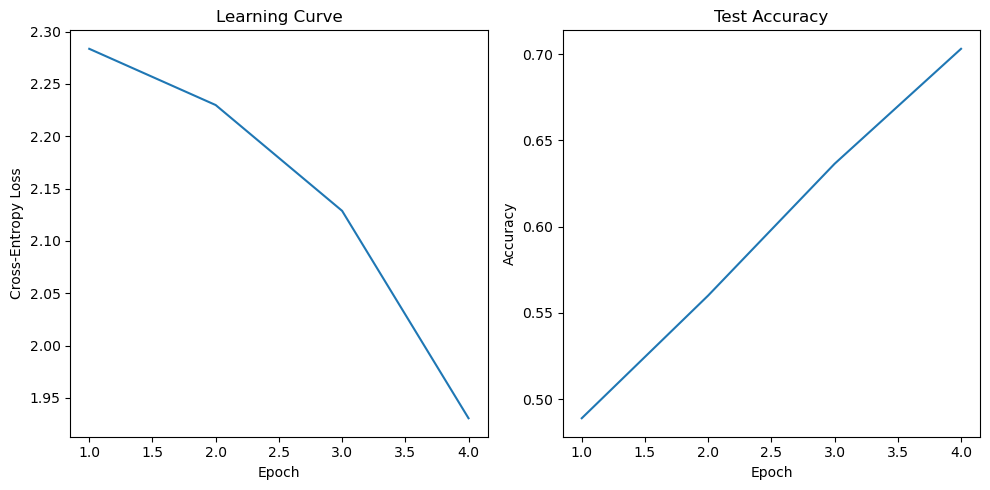

 27%|██▋       | 4/15 [12:19<33:10, 181.00s/it]

Epoch 5/15, Batch 0, Loss: 1.8536


Epoch 5/15, Batch 10, Loss: 1.6591


Epoch 5/15, Batch 20, Loss: 1.7989


Epoch 5/15, Batch 30, Loss: 1.8358


Epoch 5/15, Batch 40, Loss: 1.8261


Epoch 5/15, Batch 50, Loss: 1.7266


Epoch 5/15, Batch 60, Loss: 1.7359


Epoch 5/15, Batch 70, Loss: 1.7919


Epoch 5/15, Batch 80, Loss: 1.8238


Epoch 5/15, Batch 90, Loss: 1.8744


Epoch 5/15, Batch 100, Loss: 1.7702



 10%|▉         | 112/1167 [00:19<03:04,  5.71it/s]

Epoch 5/15, Batch 110, Loss: 1.6777


Epoch 5/15, Batch 120, Loss: 1.7762


Epoch 5/15, Batch 130, Loss: 1.7584


Epoch 5/15, Batch 140, Loss: 1.7825


Epoch 5/15, Batch 150, Loss: 1.6982


Epoch 5/15, Batch 160, Loss: 1.8398


Epoch 5/15, Batch 170, Loss: 1.8658


Epoch 5/15, Batch 180, Loss: 1.8411


Epoch 5/15, Batch 190, Loss: 1.7818


Epoch 5/15, Batch 200, Loss: 1.7453


Epoch 5/15, Batch 210, Loss: 1.7412


Epoch 5/15, Batch 220, Loss: 1.7186


Epoch 5/15, Batch 230, Loss: 1.7756


Epoch 5/15, Batch 240, Loss: 1.7758


Epoch 5/15, Batch 250, Loss: 1.7972


Epoch 5/15, Batch 260, Loss: 1.7835


Epoch 5/15, Batch 270, Loss: 1.6061


Epoch 5/15, Batch 280, Loss: 1.7574


Epoch 5/15, Batch 290, Loss: 1.7240


Epoch 5/15, Batch 300, Loss: 1.7106


Epoch 5/15, Batch 310, Loss: 1.7397


Epoch 5/15, Batch 320, Loss: 1.6779


Epoch 5/15, Batch 330, Loss: 1.6183


Epoch 5/15, Batch 340, Loss: 1.7865


Epoch 5/15, Batch 350, Loss: 1.6172


Epoch 5/15, Batch 360, Loss: 1.6541


Epoch 5/15, Batch 370, Loss: 1.6692


Epoch 5/15, Batch 380, Loss: 1.7355


Epoch 5/15, Batch 390, Loss: 1.7626


Epoch 5/15, Batch 400, Loss: 1.5963


Epoch 5/15, Batch 410, Loss: 1.7592


Epoch 5/15, Batch 420, Loss: 1.7649


Epoch 5/15, Batch 430, Loss: 1.7207


Epoch 5/15, Batch 440, Loss: 1.7145


Epoch 5/15, Batch 450, Loss: 1.6079


Epoch 5/15, Batch 460, Loss: 1.7333


Epoch 5/15, Batch 470, Loss: 1.6827


Epoch 5/15, Batch 480, Loss: 1.5654


Epoch 5/15, Batch 490, Loss: 1.6430


Epoch 5/15, Batch 500, Loss: 1.5747


Epoch 5/15, Batch 510, Loss: 1.6312


Epoch 5/15, Batch 520, Loss: 1.6122


Epoch 5/15, Batch 530, Loss: 1.6181


Epoch 5/15, Batch 540, Loss: 1.6908


Epoch 5/15, Batch 550, Loss: 1.6164


Epoch 5/15, Batch 560, Loss: 1.6874


Epoch 5/15, Batch 570, Loss: 1.6882


Epoch 5/15, Batch 580, Loss: 1.6938


Epoch 5/15, Batch 590, Loss: 1.6124


Epoch 5/15, Batch 600, Loss: 1.6753


Epoch 5/15, Batch 610, Loss: 1.6133


 52%|█████▏    | 612/1167 [01:41<01:49,  5.05it/s]

Epoch 5/15, Batch 620, Loss: 1.5717


Epoch 5/15, Batch 630, Loss: 1.5769


Epoch 5/15, Batch 640, Loss: 1.6522


Epoch 5/15, Batch 650, Loss: 1.6032


Epoch 5/15, Batch 660, Loss: 1.6068


Epoch 5/15, Batch 670, Loss: 1.6516


Epoch 5/15, Batch 680, Loss: 1.6328


Epoch 5/15, Batch 690, Loss: 1.7751


Epoch 5/15, Batch 700, Loss: 1.6005


Epoch 5/15, Batch 710, Loss: 1.5707


Epoch 5/15, Batch 720, Loss: 1.5587


Epoch 5/15, Batch 730, Loss: 1.5494


Epoch 5/15, Batch 740, Loss: 1.6107


Epoch 5/15, Batch 750, Loss: 1.6513


Epoch 5/15, Batch 760, Loss: 1.5799


Epoch 5/15, Batch 770, Loss: 1.5985


Epoch 5/15, Batch 780, Loss: 1.6816


Epoch 5/15, Batch 790, Loss: 1.5624


Epoch 5/15, Batch 800, Loss: 1.6304


Epoch 5/15, Batch 810, Loss: 1.5679


Epoch 5/15, Batch 820, Loss: 1.4951


Epoch 5/15, Batch 830, Loss: 1.6387


Epoch 5/15, Batch 840, Loss: 1.5640


Epoch 5/15, Batch 850, Loss: 1.5215


Epoch 5/15, Batch 860, Loss: 1.6277


Epoch 5/15, Batch 870, Loss: 1.5038


Epoch 5/15, Batch 880, Loss: 1.6559


Epoch 5/15, Batch 890, Loss: 1.4940


Epoch 5/15, Batch 900, Loss: 1.5696


Epoch 5/15, Batch 910, Loss: 1.4838


Epoch 5/15, Batch 920, Loss: 1.5884


Epoch 5/15, Batch 930, Loss: 1.5295


Epoch 5/15, Batch 940, Loss: 1.3982


Epoch 5/15, Batch 950, Loss: 1.4881


Epoch 5/15, Batch 960, Loss: 1.6346


Epoch 5/15, Batch 970, Loss: 1.6210


Epoch 5/15, Batch 980, Loss: 1.6246


Epoch 5/15, Batch 990, Loss: 1.4735


Epoch 5/15, Batch 1000, Loss: 1.4141


Epoch 5/15, Batch 1010, Loss: 1.5160


Epoch 5/15, Batch 1020, Loss: 1.5553


Epoch 5/15, Batch 1030, Loss: 1.5180


Epoch 5/15, Batch 1040, Loss: 1.4818


Epoch 5/15, Batch 1050, Loss: 1.4181


Epoch 5/15, Batch 1060, Loss: 1.5909


Epoch 5/15, Batch 1070, Loss: 1.6053


Epoch 5/15, Batch 1080, Loss: 1.3850


Epoch 5/15, Batch 1090, Loss: 1.5195


Epoch 5/15, Batch 1100, Loss: 1.5474


Epoch 5/15, Batch 1110, Loss: 1.5023


Epoch 5/15, Batch 1120, Loss: 1.4538


Epoch 5/15, Batch 1130, Loss: 1.4281


Epoch 5/15, Batch 1140, Loss: 1.3366


Epoch 5/15, Batch 1150, Loss: 1.3911


Epoch 5/15, Batch 1160, Loss: 1.5118


100%|██████████| 1167/1167 [03:11<00:00,  6.09it/s]


Epoch 5/15 completed. Avg Loss: 1.6391, Test Accuracy: 0.7437


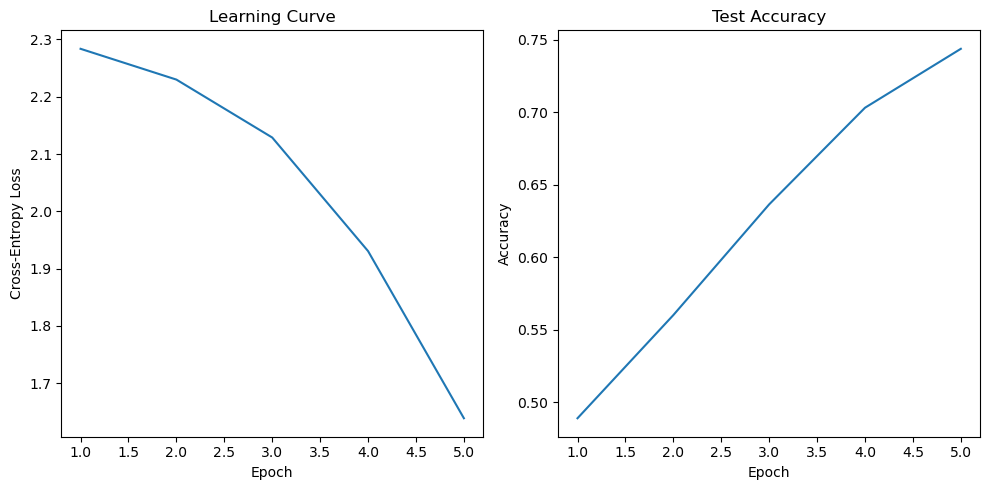

 33%|███▎      | 5/15 [15:31<30:49, 184.98s/it]

Epoch 6/15, Batch 0, Loss: 1.5385


Epoch 6/15, Batch 10, Loss: 1.2835


Epoch 6/15, Batch 20, Loss: 1.4844


Epoch 6/15, Batch 30, Loss: 1.5327


Epoch 6/15, Batch 40, Loss: 1.5000


Epoch 6/15, Batch 50, Loss: 1.3857


Epoch 6/15, Batch 60, Loss: 1.4147


Epoch 6/15, Batch 70, Loss: 1.4469


Epoch 6/15, Batch 80, Loss: 1.5525


Epoch 6/15, Batch 90, Loss: 1.5843


Epoch 6/15, Batch 100, Loss: 1.4256


Epoch 6/15, Batch 110, Loss: 1.3520


Epoch 6/15, Batch 120, Loss: 1.4682


Epoch 6/15, Batch 130, Loss: 1.4313


Epoch 6/15, Batch 140, Loss: 1.4543


Epoch 6/15, Batch 150, Loss: 1.4139


Epoch 6/15, Batch 160, Loss: 1.5002


Epoch 6/15, Batch 170, Loss: 1.5538


Epoch 6/15, Batch 180, Loss: 1.5240


Epoch 6/15, Batch 190, Loss: 1.4538


Epoch 6/15, Batch 200, Loss: 1.3899


Epoch 6/15, Batch 210, Loss: 1.4105


Epoch 6/15, Batch 220, Loss: 1.4131


Epoch 6/15, Batch 230, Loss: 1.4377


Epoch 6/15, Batch 240, Loss: 1.4564


Epoch 6/15, Batch 250, Loss: 1.4466


Epoch 6/15, Batch 260, Loss: 1.4593


Epoch 6/15, Batch 270, Loss: 1.2285


Epoch 6/15, Batch 280, Loss: 1.4385


Epoch 6/15, Batch 290, Loss: 1.3838


Epoch 6/15, Batch 300, Loss: 1.3746


Epoch 6/15, Batch 310, Loss: 1.4361


Epoch 6/15, Batch 320, Loss: 1.3369


Epoch 6/15, Batch 330, Loss: 1.2565


Epoch 6/15, Batch 340, Loss: 1.5071


Epoch 6/15, Batch 350, Loss: 1.2603


Epoch 6/15, Batch 360, Loss: 1.3149


Epoch 6/15, Batch 370, Loss: 1.3449


Epoch 6/15, Batch 380, Loss: 1.3627


Epoch 6/15, Batch 390, Loss: 1.4448


Epoch 6/15, Batch 400, Loss: 1.2363


Epoch 6/15, Batch 410, Loss: 1.4204


Epoch 6/15, Batch 420, Loss: 1.4766


Epoch 6/15, Batch 430, Loss: 1.4470


Epoch 6/15, Batch 440, Loss: 1.3960


Epoch 6/15, Batch 450, Loss: 1.2557


Epoch 6/15, Batch 460, Loss: 1.3925


Epoch 6/15, Batch 470, Loss: 1.3553


Epoch 6/15, Batch 480, Loss: 1.2247


Epoch 6/15, Batch 490, Loss: 1.2731


Epoch 6/15, Batch 500, Loss: 1.2180


Epoch 6/15, Batch 510, Loss: 1.2897


Epoch 6/15, Batch 520, Loss: 1.2684


Epoch 6/15, Batch 530, Loss: 1.2853


Epoch 6/15, Batch 540, Loss: 1.3913


Epoch 6/15, Batch 550, Loss: 1.2455


Epoch 6/15, Batch 560, Loss: 1.3639


Epoch 6/15, Batch 570, Loss: 1.3749


Epoch 6/15, Batch 580, Loss: 1.3975


Epoch 6/15, Batch 590, Loss: 1.2666


Epoch 6/15, Batch 600, Loss: 1.3408


Epoch 6/15, Batch 610, Loss: 1.2889


Epoch 6/15, Batch 620, Loss: 1.2122


Epoch 6/15, Batch 630, Loss: 1.2509


Epoch 6/15, Batch 640, Loss: 1.2932


Epoch 6/15, Batch 650, Loss: 1.3001


Epoch 6/15, Batch 660, Loss: 1.2767


Epoch 6/15, Batch 670, Loss: 1.3572


Epoch 6/15, Batch 680, Loss: 1.3260


Epoch 6/15, Batch 690, Loss: 1.4696


Epoch 6/15, Batch 700, Loss: 1.2751


Epoch 6/15, Batch 710, Loss: 1.2062


Epoch 6/15, Batch 720, Loss: 1.2160


Epoch 6/15, Batch 730, Loss: 1.2310


Epoch 6/15, Batch 740, Loss: 1.2737


Epoch 6/15, Batch 750, Loss: 1.3171


Epoch 6/15, Batch 760, Loss: 1.2659


Epoch 6/15, Batch 770, Loss: 1.2627


Epoch 6/15, Batch 780, Loss: 1.4053


Epoch 6/15, Batch 790, Loss: 1.2280


Epoch 6/15, Batch 800, Loss: 1.3213


Epoch 6/15, Batch 810, Loss: 1.2656


Epoch 6/15, Batch 820, Loss: 1.1794


Epoch 6/15, Batch 830, Loss: 1.3593


Epoch 6/15, Batch 840, Loss: 1.2710


Epoch 6/15, Batch 850, Loss: 1.1670


Epoch 6/15, Batch 860, Loss: 1.3135


Epoch 6/15, Batch 870, Loss: 1.1640


Epoch 6/15, Batch 880, Loss: 1.3460


Epoch 6/15, Batch 890, Loss: 1.1808


Epoch 6/15, Batch 900, Loss: 1.2597


Epoch 6/15, Batch 910, Loss: 1.1663


Epoch 6/15, Batch 920, Loss: 1.2968


Epoch 6/15, Batch 930, Loss: 1.2091


Epoch 6/15, Batch 940, Loss: 1.1238


Epoch 6/15, Batch 950, Loss: 1.1987


Epoch 6/15, Batch 960, Loss: 1.3200


Epoch 6/15, Batch 970, Loss: 1.3072


Epoch 6/15, Batch 980, Loss: 1.2994


Epoch 6/15, Batch 990, Loss: 1.1594


Epoch 6/15, Batch 1000, Loss: 1.1119


Epoch 6/15, Batch 1010, Loss: 1.2367


Epoch 6/15, Batch 1020, Loss: 1.2644


Epoch 6/15, Batch 1030, Loss: 1.2078


Epoch 6/15, Batch 1040, Loss: 1.1712


Epoch 6/15, Batch 1050, Loss: 1.1149


Epoch 6/15, Batch 1060, Loss: 1.3267


Epoch 6/15, Batch 1070, Loss: 1.3424


Epoch 6/15, Batch 1080, Loss: 1.0860


Epoch 6/15, Batch 1090, Loss: 1.2113


Epoch 6/15, Batch 1100, Loss: 1.2871


Epoch 6/15, Batch 1110, Loss: 1.2171


Epoch 6/15, Batch 1120, Loss: 1.1725


Epoch 6/15, Batch 1130, Loss: 1.1361


Epoch 6/15, Batch 1140, Loss: 1.0679


Epoch 6/15, Batch 1150, Loss: 1.0627


Epoch 6/15, Batch 1160, Loss: 1.2196


100%|██████████| 1167/1167 [03:01<00:00,  6.43it/s]


Epoch 6/15 completed. Avg Loss: 1.3198, Test Accuracy: 0.7885


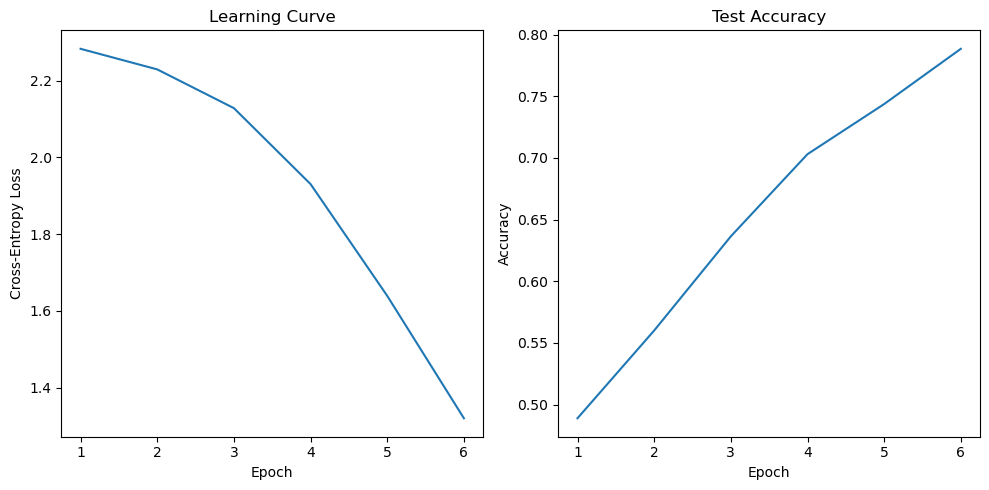

 40%|████      | 6/15 [18:33<27:35, 183.89s/it]

Epoch 7/15, Batch 0, Loss: 1.2553


Epoch 7/15, Batch 10, Loss: 0.9813


Epoch 7/15, Batch 20, Loss: 1.2264


Epoch 7/15, Batch 30, Loss: 1.2592


Epoch 7/15, Batch 40, Loss: 1.1953


Epoch 7/15, Batch 50, Loss: 1.0947


Epoch 7/15, Batch 60, Loss: 1.1359


Epoch 7/15, Batch 70, Loss: 1.1699


Epoch 7/15, Batch 80, Loss: 1.3318


Epoch 7/15, Batch 90, Loss: 1.3263


Epoch 7/15, Batch 100, Loss: 1.1298


Epoch 7/15, Batch 110, Loss: 1.1077


Epoch 7/15, Batch 120, Loss: 1.2020


Epoch 7/15, Batch 130, Loss: 1.1669


Epoch 7/15, Batch 140, Loss: 1.1933


Epoch 7/15, Batch 150, Loss: 1.2030


Epoch 7/15, Batch 160, Loss: 1.2078


 14%|█▍        | 162/1167 [00:26<03:29,  4.79it/s]

Epoch 7/15, Batch 170, Loss: 1.2770


Epoch 7/15, Batch 180, Loss: 1.2384


Epoch 7/15, Batch 190, Loss: 1.1436


Epoch 7/15, Batch 200, Loss: 1.1099


Epoch 7/15, Batch 210, Loss: 1.1258


Epoch 7/15, Batch 220, Loss: 1.1662


Epoch 7/15, Batch 230, Loss: 1.1871


Epoch 7/15, Batch 240, Loss: 1.2166


Epoch 7/15, Batch 250, Loss: 1.1787


Epoch 7/15, Batch 260, Loss: 1.1986


Epoch 7/15, Batch 270, Loss: 0.9434


Epoch 7/15, Batch 280, Loss: 1.1323


Epoch 7/15, Batch 290, Loss: 1.0914


Epoch 7/15, Batch 300, Loss: 1.0970


Epoch 7/15, Batch 310, Loss: 1.1603


Epoch 7/15, Batch 320, Loss: 1.0877


Epoch 7/15, Batch 330, Loss: 0.9767


Epoch 7/15, Batch 340, Loss: 1.2817


Epoch 7/15, Batch 350, Loss: 0.9706


Epoch 7/15, Batch 360, Loss: 1.0168


Epoch 7/15, Batch 370, Loss: 1.0900


Epoch 7/15, Batch 380, Loss: 1.0593


 33%|███▎      | 382/1167 [01:03<02:08,  6.10it/s]

Epoch 7/15, Batch 390, Loss: 1.1677


Epoch 7/15, Batch 400, Loss: 0.9291


Epoch 7/15, Batch 410, Loss: 1.1340


Epoch 7/15, Batch 420, Loss: 1.2465


Epoch 7/15, Batch 430, Loss: 1.2160


Epoch 7/15, Batch 440, Loss: 1.1560


Epoch 7/15, Batch 450, Loss: 0.9746


Epoch 7/15, Batch 460, Loss: 1.1265


Epoch 7/15, Batch 470, Loss: 1.0663


Epoch 7/15, Batch 480, Loss: 0.9561


Epoch 7/15, Batch 490, Loss: 0.9934


Epoch 7/15, Batch 500, Loss: 0.9250


Epoch 7/15, Batch 510, Loss: 1.0227


Epoch 7/15, Batch 520, Loss: 1.0145


Epoch 7/15, Batch 530, Loss: 1.0504


Epoch 7/15, Batch 540, Loss: 1.1557


Epoch 7/15, Batch 550, Loss: 0.9439


Epoch 7/15, Batch 560, Loss: 1.1255


Epoch 7/15, Batch 570, Loss: 1.1234


Epoch 7/15, Batch 580, Loss: 1.1386


Epoch 7/15, Batch 590, Loss: 0.9883


Epoch 7/15, Batch 600, Loss: 1.0768


Epoch 7/15, Batch 610, Loss: 1.0113


Epoch 7/15, Batch 620, Loss: 0.9435


 53%|█████▎    | 622/1167 [01:47<02:10,  4.17it/s]

Epoch 7/15, Batch 630, Loss: 0.9958


Epoch 7/15, Batch 640, Loss: 0.9991


Epoch 7/15, Batch 650, Loss: 1.0843


Epoch 7/15, Batch 660, Loss: 1.0392


 57%|█████▋    | 662/1167 [01:55<01:33,  5.41it/s]

Epoch 7/15, Batch 670, Loss: 1.1420


Epoch 7/15, Batch 680, Loss: 1.0836


Epoch 7/15, Batch 690, Loss: 1.2295


Epoch 7/15, Batch 700, Loss: 1.0177


Epoch 7/15, Batch 710, Loss: 0.9386


Epoch 7/15, Batch 720, Loss: 0.9463


Epoch 7/15, Batch 730, Loss: 0.9667


Epoch 7/15, Batch 740, Loss: 1.0007


Epoch 7/15, Batch 750, Loss: 1.0809


Epoch 7/15, Batch 760, Loss: 1.0201


Epoch 7/15, Batch 770, Loss: 1.0272


Epoch 7/15, Batch 780, Loss: 1.1975


Epoch 7/15, Batch 790, Loss: 0.9862


 68%|██████▊   | 792/1167 [02:19<01:14,  5.03it/s]

Epoch 7/15, Batch 800, Loss: 1.1054


Epoch 7/15, Batch 810, Loss: 1.0378


Epoch 7/15, Batch 820, Loss: 0.9727


Epoch 7/15, Batch 830, Loss: 1.1272


Epoch 7/15, Batch 840, Loss: 1.0685


Epoch 7/15, Batch 850, Loss: 0.8952


Epoch 7/15, Batch 860, Loss: 1.1064


Epoch 7/15, Batch 870, Loss: 0.9217


Epoch 7/15, Batch 880, Loss: 1.0983


Epoch 7/15, Batch 890, Loss: 0.9414


Epoch 7/15, Batch 900, Loss: 1.0438


Epoch 7/15, Batch 910, Loss: 0.9508


Epoch 7/15, Batch 920, Loss: 1.0555


Epoch 7/15, Batch 930, Loss: 0.9717


Epoch 7/15, Batch 940, Loss: 0.9229


Epoch 7/15, Batch 950, Loss: 0.9844


Epoch 7/15, Batch 960, Loss: 1.0589


Epoch 7/15, Batch 970, Loss: 1.0729


Epoch 7/15, Batch 980, Loss: 1.0253


Epoch 7/15, Batch 990, Loss: 0.9115


Epoch 7/15, Batch 1000, Loss: 0.8706


Epoch 7/15, Batch 1010, Loss: 1.0237


Epoch 7/15, Batch 1020, Loss: 1.0304


Epoch 7/15, Batch 1030, Loss: 0.9650


Epoch 7/15, Batch 1040, Loss: 0.9229


Epoch 7/15, Batch 1050, Loss: 0.8796


Epoch 7/15, Batch 1060, Loss: 1.1199


Epoch 7/15, Batch 1070, Loss: 1.1092


Epoch 7/15, Batch 1080, Loss: 0.8604


Epoch 7/15, Batch 1090, Loss: 0.9442


Epoch 7/15, Batch 1100, Loss: 1.0629


Epoch 7/15, Batch 1110, Loss: 0.9939


Epoch 7/15, Batch 1120, Loss: 0.9668


Epoch 7/15, Batch 1130, Loss: 0.8808


Epoch 7/15, Batch 1140, Loss: 0.8787


Epoch 7/15, Batch 1150, Loss: 0.8498


Epoch 7/15, Batch 1160, Loss: 0.9931


100%|██████████| 1167/1167 [03:27<00:00,  5.63it/s]


Epoch 7/15 completed. Avg Loss: 1.0649, Test Accuracy: 0.8191


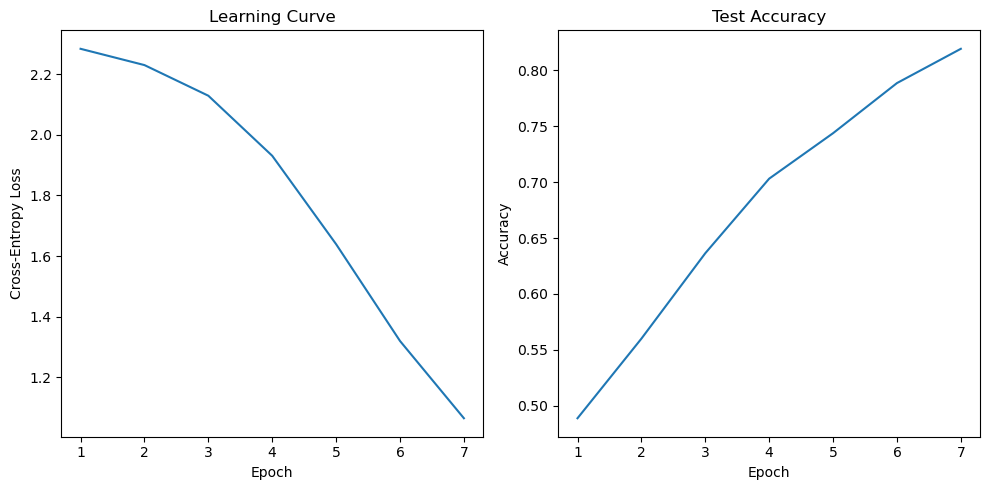

 47%|████▋     | 7/15 [22:01<25:33, 191.74s/it]

Epoch 8/15, Batch 0, Loss: 1.0289


Epoch 8/15, Batch 10, Loss: 0.7581


Epoch 8/15, Batch 20, Loss: 1.0180


Epoch 8/15, Batch 30, Loss: 1.0375


Epoch 8/15, Batch 40, Loss: 0.9875


Epoch 8/15, Batch 50, Loss: 0.8952


Epoch 8/15, Batch 60, Loss: 0.9352


Epoch 8/15, Batch 70, Loss: 0.9713


Epoch 8/15, Batch 80, Loss: 1.1471


Epoch 8/15, Batch 90, Loss: 1.1539


Epoch 8/15, Batch 100, Loss: 0.9219


Epoch 8/15, Batch 110, Loss: 0.9226


Epoch 8/15, Batch 120, Loss: 0.9972


Epoch 8/15, Batch 130, Loss: 0.9599


Epoch 8/15, Batch 140, Loss: 1.0016


Epoch 8/15, Batch 150, Loss: 1.0340


Epoch 8/15, Batch 160, Loss: 1.0209


Epoch 8/15, Batch 170, Loss: 1.0971


Epoch 8/15, Batch 180, Loss: 1.0421


Epoch 8/15, Batch 190, Loss: 0.9246


Epoch 8/15, Batch 200, Loss: 0.9058


Epoch 8/15, Batch 210, Loss: 0.9273


Epoch 8/15, Batch 220, Loss: 0.9671


Epoch 8/15, Batch 230, Loss: 0.9977


Epoch 8/15, Batch 240, Loss: 1.0490


Epoch 8/15, Batch 250, Loss: 0.9989


Epoch 8/15, Batch 260, Loss: 0.9935


Epoch 8/15, Batch 270, Loss: 0.7420


Epoch 8/15, Batch 280, Loss: 0.9247


Epoch 8/15, Batch 290, Loss: 0.8924


Epoch 8/15, Batch 300, Loss: 0.9072


Epoch 8/15, Batch 310, Loss: 0.9616


Epoch 8/15, Batch 320, Loss: 0.9001


Epoch 8/15, Batch 330, Loss: 0.7818


Epoch 8/15, Batch 340, Loss: 1.1252


 29%|██▉       | 342/1167 [01:03<02:26,  5.64it/s]

Epoch 8/15, Batch 350, Loss: 0.7658


Epoch 8/15, Batch 360, Loss: 0.8175


Epoch 8/15, Batch 370, Loss: 0.8961


Epoch 8/15, Batch 380, Loss: 0.8621


Epoch 8/15, Batch 390, Loss: 0.9742


Epoch 8/15, Batch 400, Loss: 0.7232


Epoch 8/15, Batch 410, Loss: 0.9249


Epoch 8/15, Batch 420, Loss: 1.0874


Epoch 8/15, Batch 430, Loss: 1.0332


Epoch 8/15, Batch 440, Loss: 0.9776


Epoch 8/15, Batch 450, Loss: 0.7929


Epoch 8/15, Batch 460, Loss: 0.9308


Epoch 8/15, Batch 470, Loss: 0.8870


Epoch 8/15, Batch 480, Loss: 0.7860


Epoch 8/15, Batch 490, Loss: 0.7949


Epoch 8/15, Batch 500, Loss: 0.7380


Epoch 8/15, Batch 510, Loss: 0.8293


Epoch 8/15, Batch 520, Loss: 0.8436


Epoch 8/15, Batch 530, Loss: 0.8597


Epoch 8/15, Batch 540, Loss: 1.0075


Epoch 8/15, Batch 550, Loss: 0.7298


Epoch 8/15, Batch 560, Loss: 0.9658


Epoch 8/15, Batch 570, Loss: 0.9377


Epoch 8/15, Batch 580, Loss: 0.9531


Epoch 8/15, Batch 590, Loss: 0.8084


Epoch 8/15, Batch 600, Loss: 0.8892



 52%|█████▏    | 612/1167 [01:49<01:49,  5.06it/s]

Epoch 8/15, Batch 610, Loss: 0.8280


Epoch 8/15, Batch 620, Loss: 0.7323


Epoch 8/15, Batch 630, Loss: 0.8247


Epoch 8/15, Batch 640, Loss: 0.7998


Epoch 8/15, Batch 650, Loss: 0.9458


Epoch 8/15, Batch 660, Loss: 0.8596


Epoch 8/15, Batch 670, Loss: 0.9844


Epoch 8/15, Batch 680, Loss: 0.9122



 59%|█████▉    | 692/1167 [02:04<01:22,  5.78it/s]

Epoch 8/15, Batch 690, Loss: 1.0696


Epoch 8/15, Batch 700, Loss: 0.8393


Epoch 8/15, Batch 710, Loss: 0.7812


Epoch 8/15, Batch 720, Loss: 0.7687


Epoch 8/15, Batch 730, Loss: 0.7938


Epoch 8/15, Batch 740, Loss: 0.8219


Epoch 8/15, Batch 750, Loss: 0.9063


Epoch 8/15, Batch 760, Loss: 0.8228


Epoch 8/15, Batch 770, Loss: 0.8366


Epoch 8/15, Batch 780, Loss: 1.0453


Epoch 8/15, Batch 790, Loss: 0.8097


Epoch 8/15, Batch 800, Loss: 0.9524


Epoch 8/15, Batch 810, Loss: 0.8910


Epoch 8/15, Batch 820, Loss: 0.8103


Epoch 8/15, Batch 830, Loss: 0.9765


Epoch 8/15, Batch 840, Loss: 0.9212


Epoch 8/15, Batch 850, Loss: 0.7404


Epoch 8/15, Batch 860, Loss: 0.9320


Epoch 8/15, Batch 870, Loss: 0.7404


Epoch 8/15, Batch 880, Loss: 0.9348


Epoch 8/15, Batch 890, Loss: 0.7654


Epoch 8/15, Batch 900, Loss: 0.8814


Epoch 8/15, Batch 910, Loss: 0.7862


Epoch 8/15, Batch 920, Loss: 0.8752


Epoch 8/15, Batch 930, Loss: 0.8033


Epoch 8/15, Batch 940, Loss: 0.7503


Epoch 8/15, Batch 950, Loss: 0.8336


Epoch 8/15, Batch 960, Loss: 0.8509


Epoch 8/15, Batch 970, Loss: 0.9052


Epoch 8/15, Batch 980, Loss: 0.8572


Epoch 8/15, Batch 990, Loss: 0.7368


Epoch 8/15, Batch 1000, Loss: 0.6951


Epoch 8/15, Batch 1010, Loss: 0.8513


Epoch 8/15, Batch 1020, Loss: 0.8655


Epoch 8/15, Batch 1030, Loss: 0.7994


Epoch 8/15, Batch 1040, Loss: 0.7453


Epoch 8/15, Batch 1050, Loss: 0.7053


Epoch 8/15, Batch 1060, Loss: 0.9639


Epoch 8/15, Batch 1070, Loss: 0.9718


Epoch 8/15, Batch 1080, Loss: 0.6870


Epoch 8/15, Batch 1090, Loss: 0.7597


Epoch 8/15, Batch 1100, Loss: 0.9112


Epoch 8/15, Batch 1110, Loss: 0.8445


Epoch 8/15, Batch 1120, Loss: 0.7834


Epoch 8/15, Batch 1130, Loss: 0.7025


Epoch 8/15, Batch 1140, Loss: 0.7373


Epoch 8/15, Batch 1150, Loss: 0.7073


Epoch 8/15, Batch 1160, Loss: 0.8282


100%|██████████| 1167/1167 [03:23<00:00,  5.73it/s]


Epoch 8/15 completed. Avg Loss: 0.8848, Test Accuracy: 0.8358


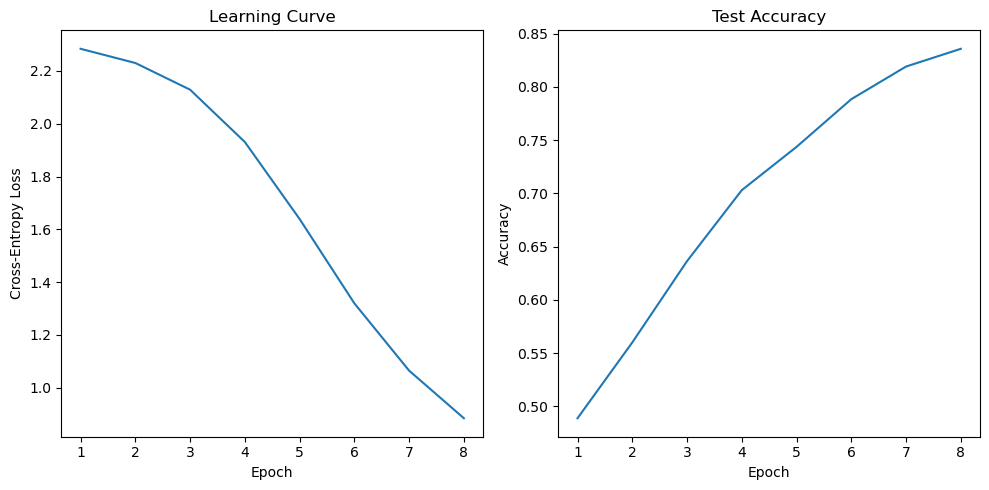

 53%|█████▎    | 8/15 [25:25<22:49, 195.70s/it]

Epoch 9/15, Batch 0, Loss: 0.8628


Epoch 9/15, Batch 10, Loss: 0.6143


Epoch 9/15, Batch 20, Loss: 0.8798


Epoch 9/15, Batch 30, Loss: 0.8860


Epoch 9/15, Batch 40, Loss: 0.8186


Epoch 9/15, Batch 50, Loss: 0.7471


Epoch 9/15, Batch 60, Loss: 0.7954


Epoch 9/15, Batch 70, Loss: 0.8119


Epoch 9/15, Batch 80, Loss: 1.0361


Epoch 9/15, Batch 90, Loss: 1.0185


Epoch 9/15, Batch 100, Loss: 0.7602


Epoch 9/15, Batch 110, Loss: 0.7703


Epoch 9/15, Batch 120, Loss: 0.8529


Epoch 9/15, Batch 130, Loss: 0.8307


Epoch 9/15, Batch 140, Loss: 0.8650


Epoch 9/15, Batch 150, Loss: 0.9372


Epoch 9/15, Batch 160, Loss: 0.8686


Epoch 9/15, Batch 170, Loss: 0.9566


Epoch 9/15, Batch 180, Loss: 0.8543


Epoch 9/15, Batch 190, Loss: 0.7767


Epoch 9/15, Batch 200, Loss: 0.7533


Epoch 9/15, Batch 210, Loss: 0.7845


Epoch 9/15, Batch 220, Loss: 0.8381


Epoch 9/15, Batch 230, Loss: 0.8754


Epoch 9/15, Batch 240, Loss: 0.9251


Epoch 9/15, Batch 250, Loss: 0.8520


Epoch 9/15, Batch 260, Loss: 0.8382


Epoch 9/15, Batch 270, Loss: 0.5902


Epoch 9/15, Batch 280, Loss: 0.7765


Epoch 9/15, Batch 290, Loss: 0.7296


Epoch 9/15, Batch 300, Loss: 0.7695


Epoch 9/15, Batch 310, Loss: 0.8057


Epoch 9/15, Batch 320, Loss: 0.7827


Epoch 9/15, Batch 330, Loss: 0.6463


Epoch 9/15, Batch 340, Loss: 1.0355


Epoch 9/15, Batch 350, Loss: 0.6446


Epoch 9/15, Batch 360, Loss: 0.6747


Epoch 9/15, Batch 370, Loss: 0.7706


Epoch 9/15, Batch 380, Loss: 0.7347


Epoch 9/15, Batch 390, Loss: 0.8344


Epoch 9/15, Batch 400, Loss: 0.5801


Epoch 9/15, Batch 410, Loss: 0.7660


Epoch 9/15, Batch 420, Loss: 0.9830


Epoch 9/15, Batch 430, Loss: 0.9276


Epoch 9/15, Batch 440, Loss: 0.8147


Epoch 9/15, Batch 450, Loss: 0.6700


Epoch 9/15, Batch 460, Loss: 0.8050


Epoch 9/15, Batch 470, Loss: 0.7758


Epoch 9/15, Batch 480, Loss: 0.6428


Epoch 9/15, Batch 490, Loss: 0.6437


Epoch 9/15, Batch 500, Loss: 0.6317


Epoch 9/15, Batch 510, Loss: 0.6933


Epoch 9/15, Batch 520, Loss: 0.7286


Epoch 9/15, Batch 530, Loss: 0.7222


Epoch 9/15, Batch 540, Loss: 0.8965


Epoch 9/15, Batch 550, Loss: 0.5916


Epoch 9/15, Batch 560, Loss: 0.8507


Epoch 9/15, Batch 570, Loss: 0.8392


Epoch 9/15, Batch 580, Loss: 0.8169


Epoch 9/15, Batch 590, Loss: 0.6869


Epoch 9/15, Batch 600, Loss: 0.7349


Epoch 9/15, Batch 610, Loss: 0.7007


Epoch 9/15, Batch 620, Loss: 0.5813


Epoch 9/15, Batch 630, Loss: 0.7061


Epoch 9/15, Batch 640, Loss: 0.6494


Epoch 9/15, Batch 650, Loss: 0.8433


Epoch 9/15, Batch 660, Loss: 0.7365


Epoch 9/15, Batch 670, Loss: 0.8981


Epoch 9/15, Batch 680, Loss: 0.8166


Epoch 9/15, Batch 690, Loss: 0.9445


Epoch 9/15, Batch 700, Loss: 0.7117


Epoch 9/15, Batch 710, Loss: 0.6877


Epoch 9/15, Batch 720, Loss: 0.6537


Epoch 9/15, Batch 730, Loss: 0.6832


Epoch 9/15, Batch 740, Loss: 0.6779


Epoch 9/15, Batch 750, Loss: 0.8036


Epoch 9/15, Batch 760, Loss: 0.6906


Epoch 9/15, Batch 770, Loss: 0.7226


Epoch 9/15, Batch 780, Loss: 0.9558


Epoch 9/15, Batch 790, Loss: 0.6823


Epoch 9/15, Batch 800, Loss: 0.8379


Epoch 9/15, Batch 810, Loss: 0.7787


Epoch 9/15, Batch 820, Loss: 0.6951


Epoch 9/15, Batch 830, Loss: 0.8836


Epoch 9/15, Batch 840, Loss: 0.8296


Epoch 9/15, Batch 850, Loss: 0.6408


Epoch 9/15, Batch 860, Loss: 0.8312


Epoch 9/15, Batch 870, Loss: 0.6215


Epoch 9/15, Batch 880, Loss: 0.8227


Epoch 9/15, Batch 890, Loss: 0.6300


Epoch 9/15, Batch 900, Loss: 0.7613


Epoch 9/15, Batch 910, Loss: 0.6805


Epoch 9/15, Batch 920, Loss: 0.7673


Epoch 9/15, Batch 930, Loss: 0.6934


Epoch 9/15, Batch 940, Loss: 0.6670


Epoch 9/15, Batch 950, Loss: 0.7356


Epoch 9/15, Batch 960, Loss: 0.7344


Epoch 9/15, Batch 970, Loss: 0.8027


Epoch 9/15, Batch 980, Loss: 0.7452


Epoch 9/15, Batch 990, Loss: 0.6359


Epoch 9/15, Batch 1000, Loss: 0.5971


Epoch 9/15, Batch 1010, Loss: 0.7424


Epoch 9/15, Batch 1020, Loss: 0.7798


Epoch 9/15, Batch 1030, Loss: 0.6957


Epoch 9/15, Batch 1040, Loss: 0.6414


Epoch 9/15, Batch 1050, Loss: 0.6097


Epoch 9/15, Batch 1060, Loss: 0.8461


Epoch 9/15, Batch 1070, Loss: 0.8452


Epoch 9/15, Batch 1080, Loss: 0.6001


Epoch 9/15, Batch 1090, Loss: 0.6426


Epoch 9/15, Batch 1100, Loss: 0.8134


Epoch 9/15, Batch 1110, Loss: 0.7521


Epoch 9/15, Batch 1120, Loss: 0.6696


Epoch 9/15, Batch 1130, Loss: 0.5993


Epoch 9/15, Batch 1140, Loss: 0.6661


Epoch 9/15, Batch 1150, Loss: 0.6257


Epoch 9/15, Batch 1160, Loss: 0.7258


100%|██████████| 1167/1167 [03:14<00:00,  6.02it/s]


Epoch 9/15 completed. Avg Loss: 0.7632, Test Accuracy: 0.8445


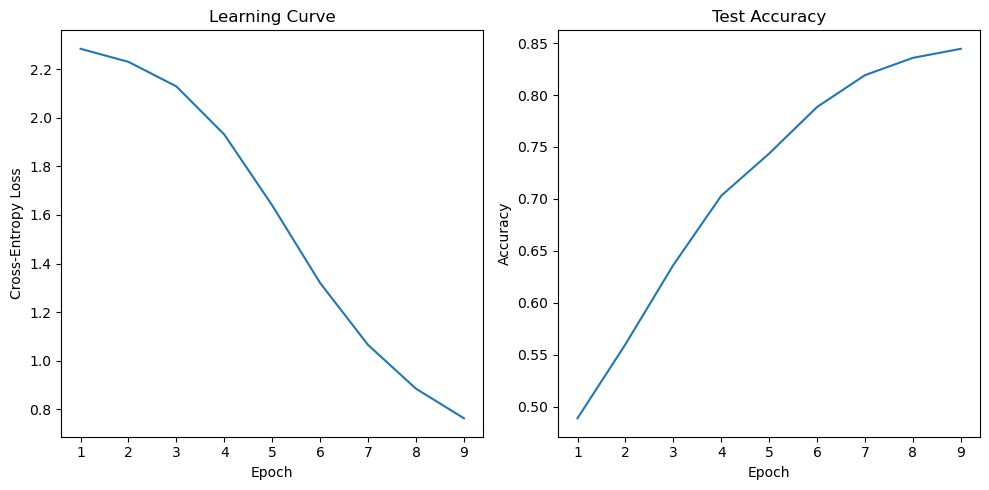

 60%|██████    | 9/15 [28:40<19:31, 195.32s/it]

Epoch 10/15, Batch 0, Loss: 0.7718


Epoch 10/15, Batch 10, Loss: 0.5169


Epoch 10/15, Batch 20, Loss: 0.7757


Epoch 10/15, Batch 30, Loss: 0.7871


Epoch 10/15, Batch 40, Loss: 0.7525


Epoch 10/15, Batch 50, Loss: 0.6623


Epoch 10/15, Batch 60, Loss: 0.7070


Epoch 10/15, Batch 70, Loss: 0.7028


Epoch 10/15, Batch 80, Loss: 0.9574


Epoch 10/15, Batch 90, Loss: 0.9170


Epoch 10/15, Batch 100, Loss: 0.6564


Epoch 10/15, Batch 110, Loss: 0.7165


Epoch 10/15, Batch 120, Loss: 0.7553


Epoch 10/15, Batch 130, Loss: 0.7536


Epoch 10/15, Batch 140, Loss: 0.7602


Epoch 10/15, Batch 150, Loss: 0.8673


Epoch 10/15, Batch 160, Loss: 0.7772


Epoch 10/15, Batch 170, Loss: 0.8845


Epoch 10/15, Batch 180, Loss: 0.7653


Epoch 10/15, Batch 190, Loss: 0.6847


Epoch 10/15, Batch 200, Loss: 0.6453


Epoch 10/15, Batch 210, Loss: 0.6787


Epoch 10/15, Batch 220, Loss: 0.7597


Epoch 10/15, Batch 230, Loss: 0.7906


Epoch 10/15, Batch 240, Loss: 0.8390


Epoch 10/15, Batch 250, Loss: 0.7722


Epoch 10/15, Batch 260, Loss: 0.7306


Epoch 10/15, Batch 270, Loss: 0.5242


Epoch 10/15, Batch 280, Loss: 0.6761


Epoch 10/15, Batch 290, Loss: 0.6497


Epoch 10/15, Batch 300, Loss: 0.6635


Epoch 10/15, Batch 310, Loss: 0.7199


Epoch 10/15, Batch 320, Loss: 0.7029


Epoch 10/15, Batch 330, Loss: 0.5719


Epoch 10/15, Batch 340, Loss: 0.9810


Epoch 10/15, Batch 350, Loss: 0.5613


Epoch 10/15, Batch 360, Loss: 0.5797


Epoch 10/15, Batch 370, Loss: 0.6797


Epoch 10/15, Batch 380, Loss: 0.6448


Epoch 10/15, Batch 390, Loss: 0.7480


Epoch 10/15, Batch 400, Loss: 0.4904


Epoch 10/15, Batch 410, Loss: 0.6823


Epoch 10/15, Batch 420, Loss: 0.9114


Epoch 10/15, Batch 430, Loss: 0.8631


Epoch 10/15, Batch 440, Loss: 0.7341


Epoch 10/15, Batch 450, Loss: 0.5910


Epoch 10/15, Batch 460, Loss: 0.7087


Epoch 10/15, Batch 470, Loss: 0.6959


Epoch 10/15, Batch 480, Loss: 0.5284


Epoch 10/15, Batch 490, Loss: 0.5464


Epoch 10/15, Batch 500, Loss: 0.5569


Epoch 10/15, Batch 510, Loss: 0.6126


Epoch 10/15, Batch 520, Loss: 0.6440


Epoch 10/15, Batch 530, Loss: 0.6238


Epoch 10/15, Batch 540, Loss: 0.8236


Epoch 10/15, Batch 550, Loss: 0.5041


Epoch 10/15, Batch 560, Loss: 0.7799


Epoch 10/15, Batch 570, Loss: 0.7556


Epoch 10/15, Batch 580, Loss: 0.7295


Epoch 10/15, Batch 590, Loss: 0.5993


Epoch 10/15, Batch 600, Loss: 0.6522


Epoch 10/15, Batch 610, Loss: 0.6071


Epoch 10/15, Batch 620, Loss: 0.5092


Epoch 10/15, Batch 630, Loss: 0.6176


Epoch 10/15, Batch 640, Loss: 0.5701


Epoch 10/15, Batch 650, Loss: 0.7756


Epoch 10/15, Batch 660, Loss: 0.6552


Epoch 10/15, Batch 670, Loss: 0.8508


Epoch 10/15, Batch 680, Loss: 0.7618


Epoch 10/15, Batch 690, Loss: 0.8710


Epoch 10/15, Batch 700, Loss: 0.6385


Epoch 10/15, Batch 710, Loss: 0.6360


Epoch 10/15, Batch 720, Loss: 0.6050


Epoch 10/15, Batch 730, Loss: 0.5975


Epoch 10/15, Batch 740, Loss: 0.6020


Epoch 10/15, Batch 750, Loss: 0.7368


Epoch 10/15, Batch 760, Loss: 0.6062


Epoch 10/15, Batch 770, Loss: 0.6335


Epoch 10/15, Batch 780, Loss: 0.8834


Epoch 10/15, Batch 790, Loss: 0.6094


Epoch 10/15, Batch 800, Loss: 0.7609


Epoch 10/15, Batch 810, Loss: 0.7147


Epoch 10/15, Batch 820, Loss: 0.6328


Epoch 10/15, Batch 830, Loss: 0.8006


Epoch 10/15, Batch 840, Loss: 0.7503


Epoch 10/15, Batch 850, Loss: 0.5708


Epoch 10/15, Batch 860, Loss: 0.7613


Epoch 10/15, Batch 870, Loss: 0.5343


Epoch 10/15, Batch 880, Loss: 0.7598


Epoch 10/15, Batch 890, Loss: 0.5321


Epoch 10/15, Batch 900, Loss: 0.6930


Epoch 10/15, Batch 910, Loss: 0.6126


Epoch 10/15, Batch 920, Loss: 0.6948


Epoch 10/15, Batch 930, Loss: 0.6079


Epoch 10/15, Batch 940, Loss: 0.6019


Epoch 10/15, Batch 950, Loss: 0.6572


Epoch 10/15, Batch 960, Loss: 0.6494


Epoch 10/15, Batch 970, Loss: 0.7168


Epoch 10/15, Batch 980, Loss: 0.6583


Epoch 10/15, Batch 990, Loss: 0.5388


Epoch 10/15, Batch 1000, Loss: 0.5259


Epoch 10/15, Batch 1010, Loss: 0.6743


Epoch 10/15, Batch 1020, Loss: 0.7101


Epoch 10/15, Batch 1030, Loss: 0.6144


Epoch 10/15, Batch 1040, Loss: 0.5653


Epoch 10/15, Batch 1050, Loss: 0.5351


Epoch 10/15, Batch 1060, Loss: 0.7639


Epoch 10/15, Batch 1070, Loss: 0.7934


Epoch 10/15, Batch 1080, Loss: 0.5326



 94%|█████████▎| 1092/1167 [02:58<00:14,  5.17it/s]

Epoch 10/15, Batch 1090, Loss: 0.5671


Epoch 10/15, Batch 1100, Loss: 0.6978


Epoch 10/15, Batch 1110, Loss: 0.6914


Epoch 10/15, Batch 1120, Loss: 0.5871


Epoch 10/15, Batch 1130, Loss: 0.5210


Epoch 10/15, Batch 1140, Loss: 0.6168


Epoch 10/15, Batch 1150, Loss: 0.5557


Epoch 10/15, Batch 1160, Loss: 0.6623


100%|██████████| 1167/1167 [03:10<00:00,  6.12it/s]


Epoch 10/15 completed. Avg Loss: 0.6836, Test Accuracy: 0.8537


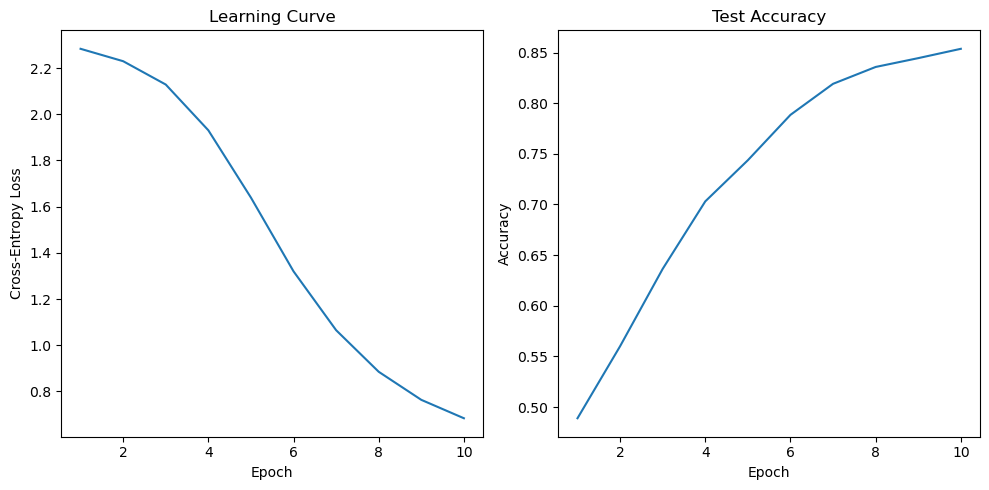

 67%|██████▋   | 10/15 [31:51<16:09, 193.98s/it]

Epoch 11/15, Batch 0, Loss: 0.7013


Epoch 11/15, Batch 10, Loss: 0.4479


Epoch 11/15, Batch 20, Loss: 0.6967


Epoch 11/15, Batch 30, Loss: 0.6906


Epoch 11/15, Batch 40, Loss: 0.6854


Epoch 11/15, Batch 50, Loss: 0.5971


Epoch 11/15, Batch 60, Loss: 0.6460


Epoch 11/15, Batch 70, Loss: 0.6155


Epoch 11/15, Batch 80, Loss: 0.8922


Epoch 11/15, Batch 90, Loss: 0.8612


Epoch 11/15, Batch 100, Loss: 0.5842


Epoch 11/15, Batch 110, Loss: 0.6592


Epoch 11/15, Batch 120, Loss: 0.7081


Epoch 11/15, Batch 130, Loss: 0.6860


Epoch 11/15, Batch 140, Loss: 0.7006


Epoch 11/15, Batch 150, Loss: 0.8174


Epoch 11/15, Batch 160, Loss: 0.7149


Epoch 11/15, Batch 170, Loss: 0.8396


Epoch 11/15, Batch 180, Loss: 0.6784


Epoch 11/15, Batch 190, Loss: 0.6028


Epoch 11/15, Batch 200, Loss: 0.5818


Epoch 11/15, Batch 210, Loss: 0.6000


Epoch 11/15, Batch 220, Loss: 0.6684


Epoch 11/15, Batch 230, Loss: 0.7004


Epoch 11/15, Batch 240, Loss: 0.7597


Epoch 11/15, Batch 250, Loss: 0.6830


Epoch 11/15, Batch 260, Loss: 0.6502


Epoch 11/15, Batch 270, Loss: 0.4408


Epoch 11/15, Batch 280, Loss: 0.6062


Epoch 11/15, Batch 290, Loss: 0.5955


Epoch 11/15, Batch 300, Loss: 0.5812


Epoch 11/15, Batch 310, Loss: 0.6590


Epoch 11/15, Batch 320, Loss: 0.6415


Epoch 11/15, Batch 330, Loss: 0.4946


Epoch 11/15, Batch 340, Loss: 0.9230


Epoch 11/15, Batch 350, Loss: 0.4938


Epoch 11/15, Batch 360, Loss: 0.5146


Epoch 11/15, Batch 370, Loss: 0.6063


Epoch 11/15, Batch 380, Loss: 0.5595


Epoch 11/15, Batch 390, Loss: 0.6822


Epoch 11/15, Batch 400, Loss: 0.4119


Epoch 11/15, Batch 410, Loss: 0.5914


Epoch 11/15, Batch 420, Loss: 0.8578


Epoch 11/15, Batch 430, Loss: 0.8130


Epoch 11/15, Batch 440, Loss: 0.6594


Epoch 11/15, Batch 450, Loss: 0.5431


Epoch 11/15, Batch 460, Loss: 0.6399


Epoch 11/15, Batch 470, Loss: 0.6331


Epoch 11/15, Batch 480, Loss: 0.4790


Epoch 11/15, Batch 490, Loss: 0.4741


Epoch 11/15, Batch 500, Loss: 0.5027


Epoch 11/15, Batch 510, Loss: 0.5475


Epoch 11/15, Batch 520, Loss: 0.5892


Epoch 11/15, Batch 530, Loss: 0.5703


Epoch 11/15, Batch 540, Loss: 0.7617


Epoch 11/15, Batch 550, Loss: 0.4264


Epoch 11/15, Batch 560, Loss: 0.7312


Epoch 11/15, Batch 570, Loss: 0.6945


Epoch 11/15, Batch 580, Loss: 0.6518


Epoch 11/15, Batch 590, Loss: 0.5306


Epoch 11/15, Batch 600, Loss: 0.5865


Epoch 11/15, Batch 610, Loss: 0.5190


Epoch 11/15, Batch 620, Loss: 0.4409


Epoch 11/15, Batch 630, Loss: 0.5492


Epoch 11/15, Batch 640, Loss: 0.4907


Epoch 11/15, Batch 650, Loss: 0.7218


Epoch 11/15, Batch 660, Loss: 0.5889


Epoch 11/15, Batch 670, Loss: 0.8030


Epoch 11/15, Batch 680, Loss: 0.6916


Epoch 11/15, Batch 690, Loss: 0.7856


Epoch 11/15, Batch 700, Loss: 0.5718


Epoch 11/15, Batch 710, Loss: 0.5994


Epoch 11/15, Batch 720, Loss: 0.5444


Epoch 11/15, Batch 730, Loss: 0.5314


Epoch 11/15, Batch 740, Loss: 0.5254


Epoch 11/15, Batch 750, Loss: 0.6544


Epoch 11/15, Batch 760, Loss: 0.5192


Epoch 11/15, Batch 770, Loss: 0.5611


Epoch 11/15, Batch 780, Loss: 0.8339


Epoch 11/15, Batch 790, Loss: 0.5419


Epoch 11/15, Batch 800, Loss: 0.6958


Epoch 11/15, Batch 810, Loss: 0.6708


Epoch 11/15, Batch 820, Loss: 0.5617


Epoch 11/15, Batch 830, Loss: 0.7776


Epoch 11/15, Batch 840, Loss: 0.7033


Epoch 11/15, Batch 850, Loss: 0.5023


Epoch 11/15, Batch 860, Loss: 0.6884


Epoch 11/15, Batch 870, Loss: 0.4595


Epoch 11/15, Batch 880, Loss: 0.6998


Epoch 11/15, Batch 890, Loss: 0.4666


Epoch 11/15, Batch 900, Loss: 0.6172


Epoch 11/15, Batch 910, Loss: 0.5599


Epoch 11/15, Batch 920, Loss: 0.6281


Epoch 11/15, Batch 930, Loss: 0.5408


Epoch 11/15, Batch 940, Loss: 0.5529


Epoch 11/15, Batch 950, Loss: 0.5994


Epoch 11/15, Batch 960, Loss: 0.5804


Epoch 11/15, Batch 970, Loss: 0.6635


Epoch 11/15, Batch 980, Loss: 0.6035


Epoch 11/15, Batch 990, Loss: 0.4629


Epoch 11/15, Batch 1000, Loss: 0.4578


Epoch 11/15, Batch 1010, Loss: 0.6059


Epoch 11/15, Batch 1020, Loss: 0.6495


Epoch 11/15, Batch 1030, Loss: 0.5513


Epoch 11/15, Batch 1040, Loss: 0.5000


Epoch 11/15, Batch 1050, Loss: 0.4727


Epoch 11/15, Batch 1060, Loss: 0.7120


Epoch 11/15, Batch 1070, Loss: 0.7203


Epoch 11/15, Batch 1080, Loss: 0.4825


Epoch 11/15, Batch 1090, Loss: 0.4849


Epoch 11/15, Batch 1100, Loss: 0.6160


Epoch 11/15, Batch 1110, Loss: 0.6467


 95%|█████████▌| 1112/1167 [03:08<00:10,  5.49it/s]

Epoch 11/15, Batch 1120, Loss: 0.5109


Epoch 11/15, Batch 1130, Loss: 0.4604


Epoch 11/15, Batch 1140, Loss: 0.5880


Epoch 11/15, Batch 1150, Loss: 0.5124


Epoch 11/15, Batch 1160, Loss: 0.5997


100%|██████████| 1167/1167 [03:17<00:00,  5.90it/s]


Epoch 11/15 completed. Avg Loss: 0.6182, Test Accuracy: 0.8621


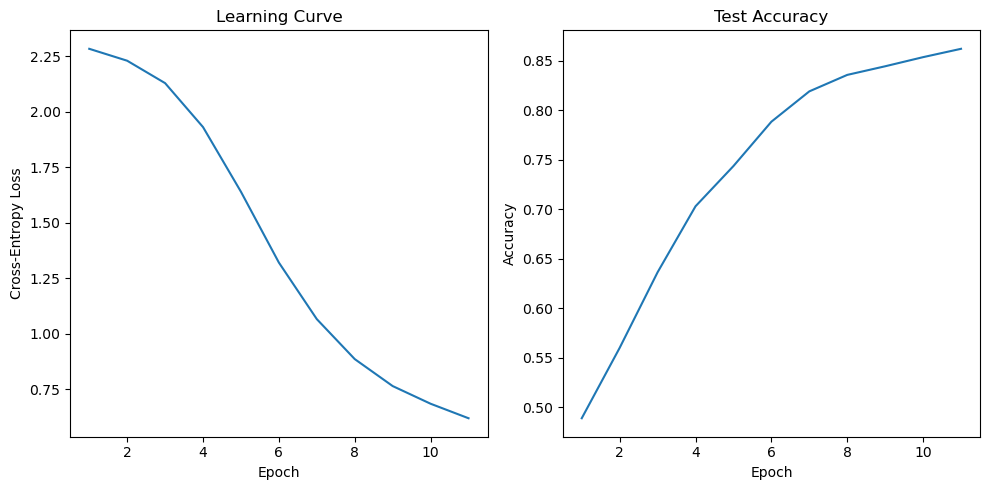

 73%|███████▎  | 11/15 [35:09<13:01, 195.27s/it]

Epoch 12/15, Batch 0, Loss: 0.6230


Epoch 12/15, Batch 10, Loss: 0.3909


Epoch 12/15, Batch 20, Loss: 0.6210


Epoch 12/15, Batch 30, Loss: 0.6440


Epoch 12/15, Batch 40, Loss: 0.6485


Epoch 12/15, Batch 50, Loss: 0.5524


Epoch 12/15, Batch 60, Loss: 0.5933


Epoch 12/15, Batch 70, Loss: 0.5597


Epoch 12/15, Batch 80, Loss: 0.8391


Epoch 12/15, Batch 90, Loss: 0.8058


Epoch 12/15, Batch 100, Loss: 0.5417


Epoch 12/15, Batch 110, Loss: 0.6079


Epoch 12/15, Batch 120, Loss: 0.6693


Epoch 12/15, Batch 130, Loss: 0.6308


Epoch 12/15, Batch 140, Loss: 0.6615


Epoch 12/15, Batch 150, Loss: 0.7618


Epoch 12/15, Batch 160, Loss: 0.6682


Epoch 12/15, Batch 170, Loss: 0.7862


Epoch 12/15, Batch 180, Loss: 0.6291


Epoch 12/15, Batch 190, Loss: 0.5522


Epoch 12/15, Batch 200, Loss: 0.5163


Epoch 12/15, Batch 210, Loss: 0.5261


Epoch 12/15, Batch 220, Loss: 0.6082


Epoch 12/15, Batch 230, Loss: 0.6265


Epoch 12/15, Batch 240, Loss: 0.6961


Epoch 12/15, Batch 250, Loss: 0.6217


Epoch 12/15, Batch 260, Loss: 0.5840


 22%|██▏       | 262/1167 [00:46<02:53,  5.21it/s]

Epoch 12/15, Batch 270, Loss: 0.3793


Epoch 12/15, Batch 280, Loss: 0.5583


Epoch 12/15, Batch 290, Loss: 0.5468


 25%|██▌       | 292/1167 [00:53<02:54,  5.02it/s]

Epoch 12/15, Batch 300, Loss: 0.5098


Epoch 12/15, Batch 310, Loss: 0.6112


Epoch 12/15, Batch 320, Loss: 0.5853


Epoch 12/15, Batch 330, Loss: 0.4446


Epoch 12/15, Batch 340, Loss: 0.8795


Epoch 12/15, Batch 350, Loss: 0.4342


Epoch 12/15, Batch 360, Loss: 0.4843


Epoch 12/15, Batch 370, Loss: 0.5482


Epoch 12/15, Batch 380, Loss: 0.5002


Epoch 12/15, Batch 390, Loss: 0.6125


Epoch 12/15, Batch 400, Loss: 0.3732


Epoch 12/15, Batch 410, Loss: 0.5159


Epoch 12/15, Batch 420, Loss: 0.8126


Epoch 12/15, Batch 430, Loss: 0.7595


Epoch 12/15, Batch 440, Loss: 0.6001


Epoch 12/15, Batch 450, Loss: 0.5041


Epoch 12/15, Batch 460, Loss: 0.5850


Epoch 12/15, Batch 470, Loss: 0.5893


Epoch 12/15, Batch 480, Loss: 0.4214


Epoch 12/15, Batch 490, Loss: 0.4246


Epoch 12/15, Batch 500, Loss: 0.4439


Epoch 12/15, Batch 510, Loss: 0.4878


Epoch 12/15, Batch 520, Loss: 0.5603


Epoch 12/15, Batch 530, Loss: 0.5137


Epoch 12/15, Batch 540, Loss: 0.7395


Epoch 12/15, Batch 550, Loss: 0.3822


Epoch 12/15, Batch 560, Loss: 0.6901


Epoch 12/15, Batch 570, Loss: 0.6338


Epoch 12/15, Batch 580, Loss: 0.6127


Epoch 12/15, Batch 590, Loss: 0.4840


Epoch 12/15, Batch 600, Loss: 0.5342


Epoch 12/15, Batch 610, Loss: 0.4850


Epoch 12/15, Batch 620, Loss: 0.4022


Epoch 12/15, Batch 630, Loss: 0.4955


Epoch 12/15, Batch 640, Loss: 0.4482


Epoch 12/15, Batch 650, Loss: 0.6890


Epoch 12/15, Batch 660, Loss: 0.5518


Epoch 12/15, Batch 670, Loss: 0.7469


Epoch 12/15, Batch 680, Loss: 0.6595


Epoch 12/15, Batch 690, Loss: 0.7327


Epoch 12/15, Batch 700, Loss: 0.5242


Epoch 12/15, Batch 710, Loss: 0.5509


Epoch 12/15, Batch 720, Loss: 0.5099


Epoch 12/15, Batch 730, Loss: 0.4910


Epoch 12/15, Batch 740, Loss: 0.4692


Epoch 12/15, Batch 750, Loss: 0.5973


Epoch 12/15, Batch 760, Loss: 0.4694


Epoch 12/15, Batch 770, Loss: 0.4962


Epoch 12/15, Batch 780, Loss: 0.8045


Epoch 12/15, Batch 790, Loss: 0.4992


Epoch 12/15, Batch 800, Loss: 0.6270


Epoch 12/15, Batch 810, Loss: 0.6495


Epoch 12/15, Batch 820, Loss: 0.5207


Epoch 12/15, Batch 830, Loss: 0.7448


Epoch 12/15, Batch 840, Loss: 0.6701


Epoch 12/15, Batch 850, Loss: 0.4481


Epoch 12/15, Batch 860, Loss: 0.6369


Epoch 12/15, Batch 870, Loss: 0.4005


Epoch 12/15, Batch 880, Loss: 0.6566


Epoch 12/15, Batch 890, Loss: 0.4193


Epoch 12/15, Batch 900, Loss: 0.5803


Epoch 12/15, Batch 910, Loss: 0.5267


Epoch 12/15, Batch 920, Loss: 0.5711


 79%|███████▉  | 922/1167 [02:37<00:46,  5.24it/s]

Epoch 12/15, Batch 930, Loss: 0.5019


Epoch 12/15, Batch 940, Loss: 0.5192


Epoch 12/15, Batch 950, Loss: 0.5674


Epoch 12/15, Batch 960, Loss: 0.5275


Epoch 12/15, Batch 970, Loss: 0.6295


Epoch 12/15, Batch 980, Loss: 0.5694


Epoch 12/15, Batch 990, Loss: 0.4245


Epoch 12/15, Batch 1000, Loss: 0.4228


Epoch 12/15, Batch 1010, Loss: 0.5594


Epoch 12/15, Batch 1020, Loss: 0.6144


Epoch 12/15, Batch 1030, Loss: 0.4888


Epoch 12/15, Batch 1040, Loss: 0.4437


Epoch 12/15, Batch 1050, Loss: 0.4262


Epoch 12/15, Batch 1060, Loss: 0.6737


Epoch 12/15, Batch 1070, Loss: 0.6591


Epoch 12/15, Batch 1080, Loss: 0.4425


Epoch 12/15, Batch 1090, Loss: 0.4353


Epoch 12/15, Batch 1100, Loss: 0.5518


Epoch 12/15, Batch 1110, Loss: 0.6071


Epoch 12/15, Batch 1120, Loss: 0.4512


Epoch 12/15, Batch 1130, Loss: 0.4284


Epoch 12/15, Batch 1140, Loss: 0.5756


Epoch 12/15, Batch 1150, Loss: 0.4827


Epoch 12/15, Batch 1160, Loss: 0.5504


100%|██████████| 1167/1167 [03:19<00:00,  5.86it/s]


Epoch 12/15 completed. Avg Loss: 0.5698, Test Accuracy: 0.8673


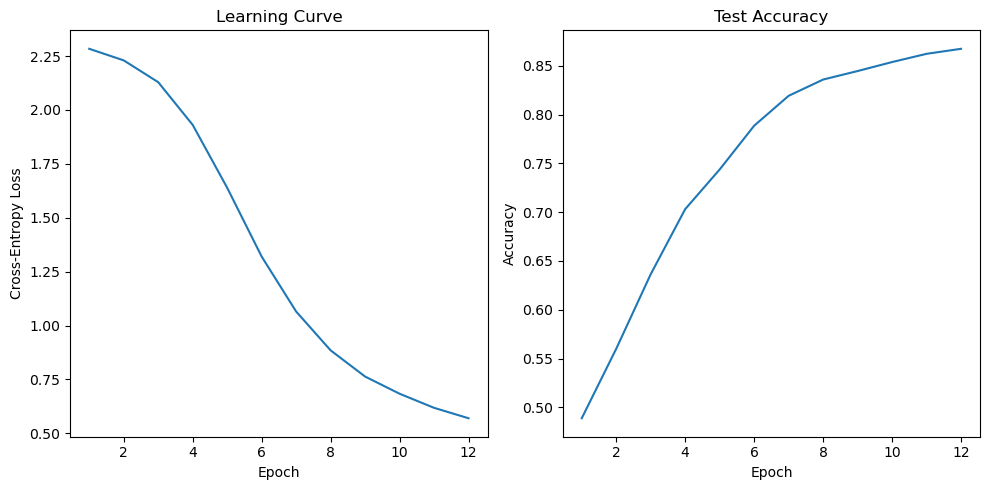

 80%|████████  | 12/15 [38:28<09:49, 196.59s/it]

Epoch 13/15, Batch 0, Loss: 0.5625


Epoch 13/15, Batch 10, Loss: 0.3527


Epoch 13/15, Batch 20, Loss: 0.5570


Epoch 13/15, Batch 30, Loss: 0.5898


Epoch 13/15, Batch 40, Loss: 0.6128


Epoch 13/15, Batch 50, Loss: 0.5357


Epoch 13/15, Batch 60, Loss: 0.5670


Epoch 13/15, Batch 70, Loss: 0.5242


Epoch 13/15, Batch 80, Loss: 0.8158


Epoch 13/15, Batch 90, Loss: 0.7498


Epoch 13/15, Batch 100, Loss: 0.5050


Epoch 13/15, Batch 110, Loss: 0.5855


Epoch 13/15, Batch 120, Loss: 0.6509


Epoch 13/15, Batch 130, Loss: 0.5896


Epoch 13/15, Batch 140, Loss: 0.6221


Epoch 13/15, Batch 150, Loss: 0.7078


Epoch 13/15, Batch 160, Loss: 0.6107


Epoch 13/15, Batch 170, Loss: 0.7551


Epoch 13/15, Batch 180, Loss: 0.5957


Epoch 13/15, Batch 190, Loss: 0.5072


Epoch 13/15, Batch 200, Loss: 0.4507


Epoch 13/15, Batch 210, Loss: 0.4856


Epoch 13/15, Batch 220, Loss: 0.5601


Epoch 13/15, Batch 230, Loss: 0.5741


Epoch 13/15, Batch 240, Loss: 0.6623


Epoch 13/15, Batch 250, Loss: 0.5638


Epoch 13/15, Batch 260, Loss: 0.5223


Epoch 13/15, Batch 270, Loss: 0.3361


Epoch 13/15, Batch 280, Loss: 0.5168


Epoch 13/15, Batch 290, Loss: 0.5058


Epoch 13/15, Batch 300, Loss: 0.4596


Epoch 13/15, Batch 310, Loss: 0.5688


Epoch 13/15, Batch 320, Loss: 0.5364


Epoch 13/15, Batch 330, Loss: 0.3980


Epoch 13/15, Batch 340, Loss: 0.8500


Epoch 13/15, Batch 350, Loss: 0.4032


Epoch 13/15, Batch 360, Loss: 0.4434


Epoch 13/15, Batch 370, Loss: 0.5064


Epoch 13/15, Batch 380, Loss: 0.4686


Epoch 13/15, Batch 390, Loss: 0.5865


Epoch 13/15, Batch 400, Loss: 0.3409


Epoch 13/15, Batch 410, Loss: 0.4690


Epoch 13/15, Batch 420, Loss: 0.7777


Epoch 13/15, Batch 430, Loss: 0.7227


Epoch 13/15, Batch 440, Loss: 0.5748


Epoch 13/15, Batch 450, Loss: 0.4643


Epoch 13/15, Batch 460, Loss: 0.5538


Epoch 13/15, Batch 470, Loss: 0.5522


Epoch 13/15, Batch 480, Loss: 0.3907


Epoch 13/15, Batch 490, Loss: 0.3815


Epoch 13/15, Batch 500, Loss: 0.4173


Epoch 13/15, Batch 510, Loss: 0.4481


Epoch 13/15, Batch 520, Loss: 0.5224


Epoch 13/15, Batch 530, Loss: 0.4927


Epoch 13/15, Batch 540, Loss: 0.7055


Epoch 13/15, Batch 550, Loss: 0.3327


Epoch 13/15, Batch 560, Loss: 0.6557


Epoch 13/15, Batch 570, Loss: 0.5963


Epoch 13/15, Batch 580, Loss: 0.5780


Epoch 13/15, Batch 590, Loss: 0.4377


Epoch 13/15, Batch 600, Loss: 0.5089


Epoch 13/15, Batch 610, Loss: 0.4436


Epoch 13/15, Batch 620, Loss: 0.3663


Epoch 13/15, Batch 630, Loss: 0.4622


Epoch 13/15, Batch 640, Loss: 0.4083


Epoch 13/15, Batch 650, Loss: 0.6546


Epoch 13/15, Batch 660, Loss: 0.5193


Epoch 13/15, Batch 670, Loss: 0.7463


Epoch 13/15, Batch 680, Loss: 0.6255


Epoch 13/15, Batch 690, Loss: 0.6973


Epoch 13/15, Batch 700, Loss: 0.4787


Epoch 13/15, Batch 710, Loss: 0.5220


Epoch 13/15, Batch 720, Loss: 0.4832


Epoch 13/15, Batch 730, Loss: 0.4636


Epoch 13/15, Batch 740, Loss: 0.4270


Epoch 13/15, Batch 750, Loss: 0.5601


Epoch 13/15, Batch 760, Loss: 0.4257


Epoch 13/15, Batch 770, Loss: 0.4536


Epoch 13/15, Batch 780, Loss: 0.7886


Epoch 13/15, Batch 790, Loss: 0.4623


Epoch 13/15, Batch 800, Loss: 0.6050


Epoch 13/15, Batch 810, Loss: 0.6215


Epoch 13/15, Batch 820, Loss: 0.4975


Epoch 13/15, Batch 830, Loss: 0.7025


Epoch 13/15, Batch 840, Loss: 0.6423


Epoch 13/15, Batch 850, Loss: 0.4078


Epoch 13/15, Batch 860, Loss: 0.5962


Epoch 13/15, Batch 870, Loss: 0.3539


Epoch 13/15, Batch 880, Loss: 0.6303


Epoch 13/15, Batch 890, Loss: 0.3780


Epoch 13/15, Batch 900, Loss: 0.5430


Epoch 13/15, Batch 910, Loss: 0.4995


Epoch 13/15, Batch 920, Loss: 0.5264


Epoch 13/15, Batch 930, Loss: 0.4485


Epoch 13/15, Batch 940, Loss: 0.4876


Epoch 13/15, Batch 950, Loss: 0.5415


Epoch 13/15, Batch 960, Loss: 0.4793


Epoch 13/15, Batch 970, Loss: 0.6010


Epoch 13/15, Batch 980, Loss: 0.5318


Epoch 13/15, Batch 990, Loss: 0.3807


Epoch 13/15, Batch 1000, Loss: 0.3775


Epoch 13/15, Batch 1010, Loss: 0.5313


Epoch 13/15, Batch 1020, Loss: 0.5754


Epoch 13/15, Batch 1030, Loss: 0.4567


Epoch 13/15, Batch 1040, Loss: 0.4184


Epoch 13/15, Batch 1050, Loss: 0.3861


Epoch 13/15, Batch 1060, Loss: 0.6555


Epoch 13/15, Batch 1070, Loss: 0.6405


Epoch 13/15, Batch 1080, Loss: 0.4109


Epoch 13/15, Batch 1090, Loss: 0.3787


Epoch 13/15, Batch 1100, Loss: 0.4961


Epoch 13/15, Batch 1110, Loss: 0.5825


Epoch 13/15, Batch 1120, Loss: 0.4159


Epoch 13/15, Batch 1130, Loss: 0.3892


Epoch 13/15, Batch 1140, Loss: 0.5586


Epoch 13/15, Batch 1150, Loss: 0.4533


Epoch 13/15, Batch 1160, Loss: 0.5305


100%|██████████| 1167/1167 [03:00<00:00,  6.46it/s]


Epoch 13/15 completed. Avg Loss: 0.5338, Test Accuracy: 0.8705


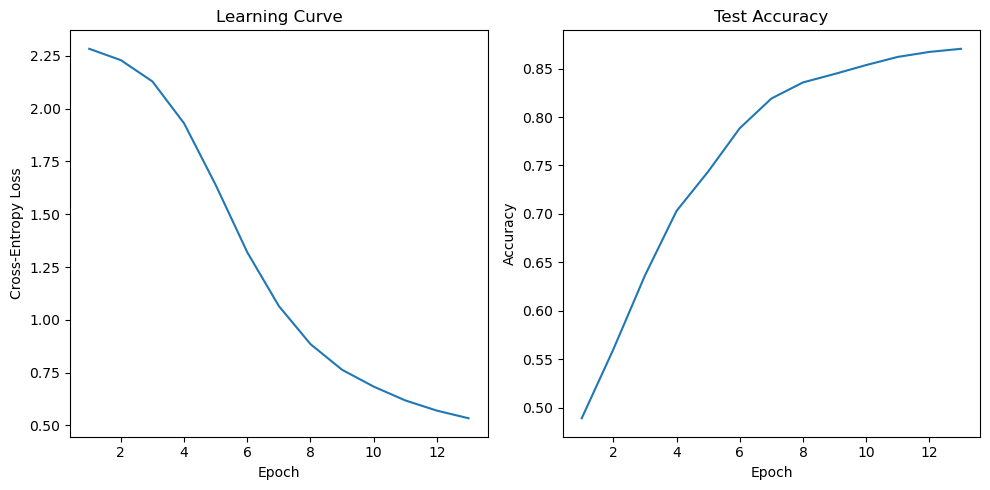

 87%|████████▋ | 13/15 [41:29<06:23, 191.91s/it]

Epoch 14/15, Batch 0, Loss: 0.5408


Epoch 14/15, Batch 10, Loss: 0.3199


Epoch 14/15, Batch 20, Loss: 0.5200


Epoch 14/15, Batch 30, Loss: 0.5579


Epoch 14/15, Batch 40, Loss: 0.5656


Epoch 14/15, Batch 50, Loss: 0.4992


Epoch 14/15, Batch 60, Loss: 0.5386


Epoch 14/15, Batch 70, Loss: 0.4905


Epoch 14/15, Batch 80, Loss: 0.8072


Epoch 14/15, Batch 90, Loss: 0.7167


Epoch 14/15, Batch 100, Loss: 0.4721


Epoch 14/15, Batch 110, Loss: 0.5660


Epoch 14/15, Batch 120, Loss: 0.6344


Epoch 14/15, Batch 130, Loss: 0.5683


Epoch 14/15, Batch 140, Loss: 0.6065


Epoch 14/15, Batch 150, Loss: 0.6936


Epoch 14/15, Batch 160, Loss: 0.5804


Epoch 14/15, Batch 170, Loss: 0.7396


Epoch 14/15, Batch 180, Loss: 0.5572


Epoch 14/15, Batch 190, Loss: 0.4730


Epoch 14/15, Batch 200, Loss: 0.4329


Epoch 14/15, Batch 210, Loss: 0.4573


Epoch 14/15, Batch 220, Loss: 0.5354


Epoch 14/15, Batch 230, Loss: 0.5170


Epoch 14/15, Batch 240, Loss: 0.6299


Epoch 14/15, Batch 250, Loss: 0.5423


Epoch 14/15, Batch 260, Loss: 0.4923


Epoch 14/15, Batch 270, Loss: 0.3044


Epoch 14/15, Batch 280, Loss: 0.4900


Epoch 14/15, Batch 290, Loss: 0.4632


Epoch 14/15, Batch 300, Loss: 0.4218


Epoch 14/15, Batch 310, Loss: 0.5395


Epoch 14/15, Batch 320, Loss: 0.5258


Epoch 14/15, Batch 330, Loss: 0.3771


Epoch 14/15, Batch 340, Loss: 0.8527


Epoch 14/15, Batch 350, Loss: 0.3586


Epoch 14/15, Batch 360, Loss: 0.4188


Epoch 14/15, Batch 370, Loss: 0.4704


Epoch 14/15, Batch 380, Loss: 0.4428


Epoch 14/15, Batch 390, Loss: 0.5571


Epoch 14/15, Batch 400, Loss: 0.3171


Epoch 14/15, Batch 410, Loss: 0.4369


Epoch 14/15, Batch 420, Loss: 0.8009


Epoch 14/15, Batch 430, Loss: 0.6924


 38%|███▊      | 442/1167 [01:16<02:07,  5.67it/s]

Epoch 14/15, Batch 440, Loss: 0.5232


Epoch 14/15, Batch 450, Loss: 0.4512


Epoch 14/15, Batch 460, Loss: 0.5338


Epoch 14/15, Batch 470, Loss: 0.5248


Epoch 14/15, Batch 480, Loss: 0.3635


Epoch 14/15, Batch 490, Loss: 0.3554


Epoch 14/15, Batch 500, Loss: 0.3869


Epoch 14/15, Batch 510, Loss: 0.4234


Epoch 14/15, Batch 520, Loss: 0.4860


Epoch 14/15, Batch 530, Loss: 0.4740


Epoch 14/15, Batch 540, Loss: 0.6759


Epoch 14/15, Batch 550, Loss: 0.2980


Epoch 14/15, Batch 560, Loss: 0.6337


Epoch 14/15, Batch 570, Loss: 0.5841


Epoch 14/15, Batch 580, Loss: 0.5467


Epoch 14/15, Batch 590, Loss: 0.3975


Epoch 14/15, Batch 600, Loss: 0.4805


Epoch 14/15, Batch 610, Loss: 0.4090


Epoch 14/15, Batch 620, Loss: 0.3321


Epoch 14/15, Batch 630, Loss: 0.4284


Epoch 14/15, Batch 640, Loss: 0.3714


Epoch 14/15, Batch 650, Loss: 0.6175


Epoch 14/15, Batch 660, Loss: 0.4846


Epoch 14/15, Batch 670, Loss: 0.7510


Epoch 14/15, Batch 680, Loss: 0.5961


Epoch 14/15, Batch 690, Loss: 0.6675


Epoch 14/15, Batch 700, Loss: 0.4592


Epoch 14/15, Batch 710, Loss: 0.5059


Epoch 14/15, Batch 720, Loss: 0.4410


Epoch 14/15, Batch 730, Loss: 0.4283


Epoch 14/15, Batch 740, Loss: 0.3989


Epoch 14/15, Batch 750, Loss: 0.5383


Epoch 14/15, Batch 760, Loss: 0.3940


Epoch 14/15, Batch 770, Loss: 0.4186


Epoch 14/15, Batch 780, Loss: 0.7594


Epoch 14/15, Batch 790, Loss: 0.4347


Epoch 14/15, Batch 800, Loss: 0.5792


Epoch 14/15, Batch 810, Loss: 0.6088


Epoch 14/15, Batch 820, Loss: 0.4745


Epoch 14/15, Batch 830, Loss: 0.7159


Epoch 14/15, Batch 840, Loss: 0.6119


Epoch 14/15, Batch 850, Loss: 0.3875


Epoch 14/15, Batch 860, Loss: 0.5719


Epoch 14/15, Batch 870, Loss: 0.3227


Epoch 14/15, Batch 880, Loss: 0.6155


Epoch 14/15, Batch 890, Loss: 0.3477


Epoch 14/15, Batch 900, Loss: 0.5040


Epoch 14/15, Batch 910, Loss: 0.4770


Epoch 14/15, Batch 920, Loss: 0.4959


Epoch 14/15, Batch 930, Loss: 0.4216


Epoch 14/15, Batch 940, Loss: 0.4575


Epoch 14/15, Batch 950, Loss: 0.5279


Epoch 14/15, Batch 960, Loss: 0.4540


Epoch 14/15, Batch 970, Loss: 0.5768


Epoch 14/15, Batch 980, Loss: 0.5182


Epoch 14/15, Batch 990, Loss: 0.3643


Epoch 14/15, Batch 1000, Loss: 0.3576


Epoch 14/15, Batch 1010, Loss: 0.4969


Epoch 14/15, Batch 1020, Loss: 0.5543


Epoch 14/15, Batch 1030, Loss: 0.4363


Epoch 14/15, Batch 1040, Loss: 0.3744


Epoch 14/15, Batch 1050, Loss: 0.3631


Epoch 14/15, Batch 1060, Loss: 0.6158



 92%|█████████▏| 1072/1167 [02:59<00:18,  5.05it/s]

Epoch 14/15, Batch 1070, Loss: 0.5885


Epoch 14/15, Batch 1080, Loss: 0.4021


Epoch 14/15, Batch 1090, Loss: 0.3418


Epoch 14/15, Batch 1100, Loss: 0.4579


Epoch 14/15, Batch 1110, Loss: 0.5580


Epoch 14/15, Batch 1120, Loss: 0.3891


Epoch 14/15, Batch 1130, Loss: 0.3576


Epoch 14/15, Batch 1140, Loss: 0.5411


Epoch 14/15, Batch 1150, Loss: 0.4363


Epoch 14/15, Batch 1160, Loss: 0.5022


100%|██████████| 1167/1167 [03:14<00:00,  5.99it/s]


Epoch 14/15 completed. Avg Loss: 0.5063, Test Accuracy: 0.8769


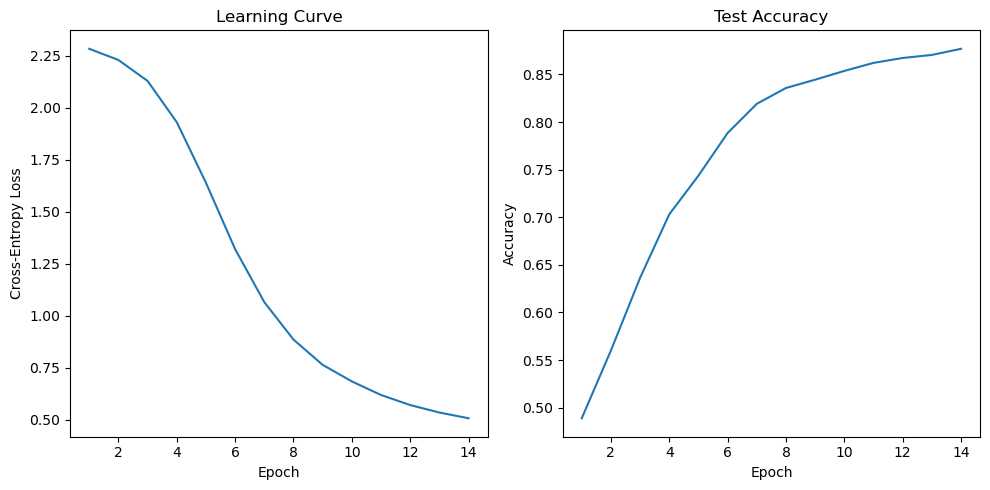

 93%|█████████▎| 14/15 [44:45<03:12, 192.93s/it]

Epoch 15/15, Batch 0, Loss: 0.5129


Epoch 15/15, Batch 10, Loss: 0.3007


Epoch 15/15, Batch 20, Loss: 0.5105


Epoch 15/15, Batch 30, Loss: 0.5442


Epoch 15/15, Batch 40, Loss: 0.5466


Epoch 15/15, Batch 50, Loss: 0.4769


Epoch 15/15, Batch 60, Loss: 0.5056


Epoch 15/15, Batch 70, Loss: 0.4601


Epoch 15/15, Batch 80, Loss: 0.8013


Epoch 15/15, Batch 90, Loss: 0.6849


Epoch 15/15, Batch 100, Loss: 0.4453


Epoch 15/15, Batch 110, Loss: 0.5409


Epoch 15/15, Batch 120, Loss: 0.6288


Epoch 15/15, Batch 130, Loss: 0.5375


Epoch 15/15, Batch 140, Loss: 0.5794


Epoch 15/15, Batch 150, Loss: 0.6651


Epoch 15/15, Batch 160, Loss: 0.5471


Epoch 15/15, Batch 170, Loss: 0.7396


Epoch 15/15, Batch 180, Loss: 0.5190


Epoch 15/15, Batch 190, Loss: 0.4395


Epoch 15/15, Batch 200, Loss: 0.4126


Epoch 15/15, Batch 210, Loss: 0.4251


Epoch 15/15, Batch 220, Loss: 0.5060


Epoch 15/15, Batch 230, Loss: 0.4748


Epoch 15/15, Batch 240, Loss: 0.5889


Epoch 15/15, Batch 250, Loss: 0.5024


Epoch 15/15, Batch 260, Loss: 0.4680


Epoch 15/15, Batch 270, Loss: 0.2794


Epoch 15/15, Batch 280, Loss: 0.4776


Epoch 15/15, Batch 290, Loss: 0.4562


Epoch 15/15, Batch 300, Loss: 0.4005


Epoch 15/15, Batch 310, Loss: 0.5122


Epoch 15/15, Batch 320, Loss: 0.4894


Epoch 15/15, Batch 330, Loss: 0.3464


Epoch 15/15, Batch 340, Loss: 0.8275


Epoch 15/15, Batch 350, Loss: 0.3346


Epoch 15/15, Batch 360, Loss: 0.3937


Epoch 15/15, Batch 370, Loss: 0.4358


Epoch 15/15, Batch 380, Loss: 0.4272


Epoch 15/15, Batch 390, Loss: 0.5341


Epoch 15/15, Batch 400, Loss: 0.3082


Epoch 15/15, Batch 410, Loss: 0.3908


Epoch 15/15, Batch 420, Loss: 0.7697


Epoch 15/15, Batch 430, Loss: 0.6679


Epoch 15/15, Batch 440, Loss: 0.5058


Epoch 15/15, Batch 450, Loss: 0.4163


Epoch 15/15, Batch 460, Loss: 0.5094


Epoch 15/15, Batch 470, Loss: 0.5063


Epoch 15/15, Batch 480, Loss: 0.3456


Epoch 15/15, Batch 490, Loss: 0.3333


Epoch 15/15, Batch 500, Loss: 0.3560


Epoch 15/15, Batch 510, Loss: 0.3926


Epoch 15/15, Batch 520, Loss: 0.4636


Epoch 15/15, Batch 530, Loss: 0.4281


Epoch 15/15, Batch 540, Loss: 0.6531


Epoch 15/15, Batch 550, Loss: 0.2746


Epoch 15/15, Batch 560, Loss: 0.6174


Epoch 15/15, Batch 570, Loss: 0.5300


Epoch 15/15, Batch 580, Loss: 0.5228


Epoch 15/15, Batch 590, Loss: 0.3823


Epoch 15/15, Batch 600, Loss: 0.4566


Epoch 15/15, Batch 610, Loss: 0.3866


Epoch 15/15, Batch 620, Loss: 0.3135


Epoch 15/15, Batch 630, Loss: 0.3965


Epoch 15/15, Batch 640, Loss: 0.3408


Epoch 15/15, Batch 650, Loss: 0.5918


Epoch 15/15, Batch 660, Loss: 0.4564


Epoch 15/15, Batch 670, Loss: 0.7417


Epoch 15/15, Batch 680, Loss: 0.5565


Epoch 15/15, Batch 690, Loss: 0.6412


Epoch 15/15, Batch 700, Loss: 0.4341


Epoch 15/15, Batch 710, Loss: 0.4852


Epoch 15/15, Batch 720, Loss: 0.4170


Epoch 15/15, Batch 730, Loss: 0.4036


Epoch 15/15, Batch 740, Loss: 0.3666


Epoch 15/15, Batch 750, Loss: 0.5086


Epoch 15/15, Batch 760, Loss: 0.3720


Epoch 15/15, Batch 770, Loss: 0.3923


Epoch 15/15, Batch 780, Loss: 0.7393


Epoch 15/15, Batch 790, Loss: 0.3943


Epoch 15/15, Batch 800, Loss: 0.5499


Epoch 15/15, Batch 810, Loss: 0.5836


Epoch 15/15, Batch 820, Loss: 0.4470


Epoch 15/15, Batch 830, Loss: 0.7212


Epoch 15/15, Batch 840, Loss: 0.5692


Epoch 15/15, Batch 850, Loss: 0.3634


Epoch 15/15, Batch 860, Loss: 0.5516


Epoch 15/15, Batch 870, Loss: 0.3000


Epoch 15/15, Batch 880, Loss: 0.5714


Epoch 15/15, Batch 890, Loss: 0.3164


Epoch 15/15, Batch 900, Loss: 0.4726


Epoch 15/15, Batch 910, Loss: 0.4427


Epoch 15/15, Batch 920, Loss: 0.4684


Epoch 15/15, Batch 930, Loss: 0.4017


Epoch 15/15, Batch 940, Loss: 0.4445


Epoch 15/15, Batch 950, Loss: 0.4993


Epoch 15/15, Batch 960, Loss: 0.4215


Epoch 15/15, Batch 970, Loss: 0.5632


Epoch 15/15, Batch 980, Loss: 0.4989


Epoch 15/15, Batch 990, Loss: 0.3475


Epoch 15/15, Batch 1000, Loss: 0.3276


Epoch 15/15, Batch 1010, Loss: 0.4941


Epoch 15/15, Batch 1020, Loss: 0.5472


Epoch 15/15, Batch 1030, Loss: 0.4163


Epoch 15/15, Batch 1040, Loss: 0.3492


Epoch 15/15, Batch 1050, Loss: 0.3352


Epoch 15/15, Batch 1060, Loss: 0.5945


Epoch 15/15, Batch 1070, Loss: 0.5584


Epoch 15/15, Batch 1080, Loss: 0.3832


Epoch 15/15, Batch 1090, Loss: 0.3283


Epoch 15/15, Batch 1100, Loss: 0.4416


Epoch 15/15, Batch 1110, Loss: 0.5382


Epoch 15/15, Batch 1120, Loss: 0.3778


Epoch 15/15, Batch 1130, Loss: 0.3358


Epoch 15/15, Batch 1140, Loss: 0.5129


Epoch 15/15, Batch 1150, Loss: 0.4167


Epoch 15/15, Batch 1160, Loss: 0.4718


100%|██████████| 1167/1167 [03:11<00:00,  6.08it/s]


Epoch 15/15 completed. Avg Loss: 0.4824, Test Accuracy: 0.8796


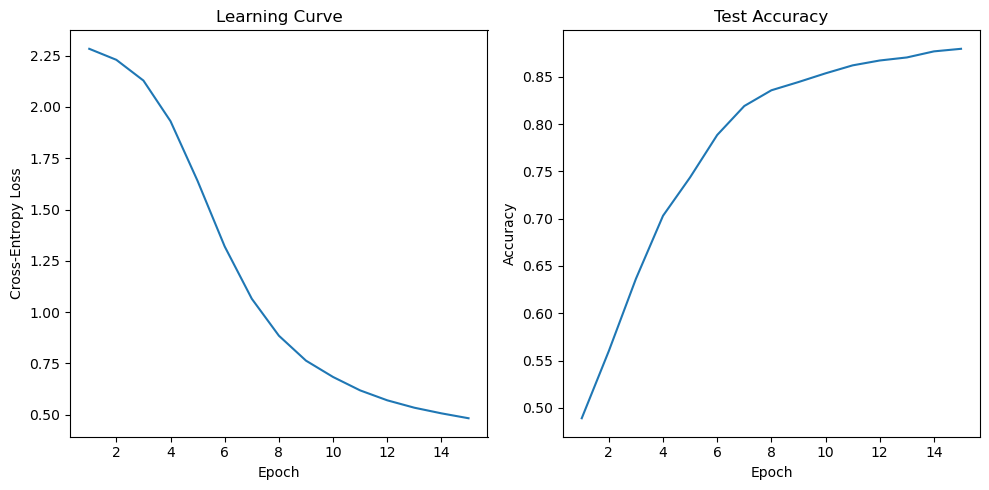

100%|██████████| 15/15 [47:57<00:00, 191.84s/it]


Training completed. Generating final visualizations...


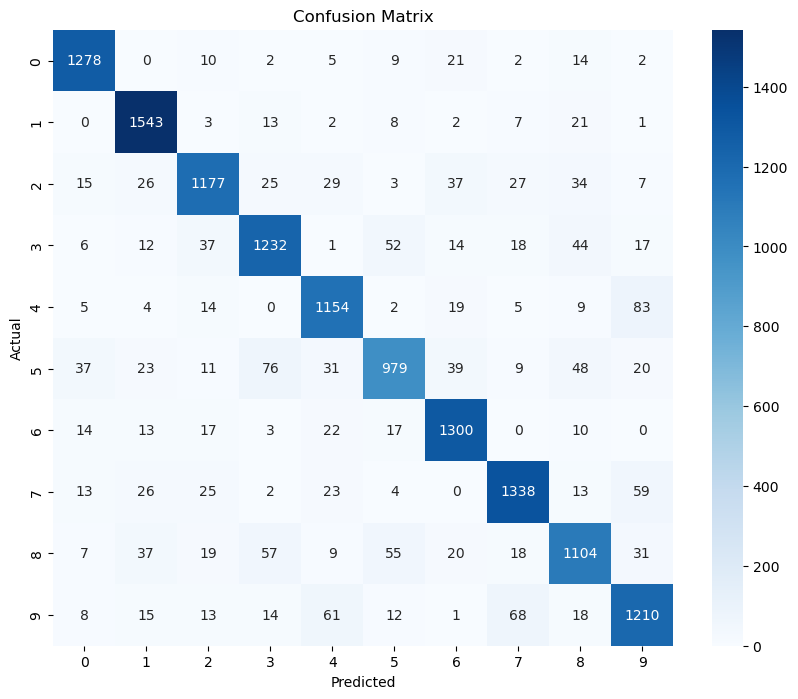

All done!


In [35]:
#WeightPerturb V2:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

class WeightPerturbMLP:
    def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
        self.W_h = np.random.normal(0, sigma, (input_size, hidden_size))
        self.W_y = np.random.normal(0, sigma, (hidden_size, output_size))
        self.sigma = sigma

    def forward(self, X):
        self.h = np.maximum(0, X @ self.W_h)  # ReLU activation
        self.y = self.h @ self.W_y
        return self.y

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def loss(self, X, targets):
        outputs = self.softmax(self.forward(X))
        return -np.mean(np.sum(targets * np.log(outputs + 1e-10), axis=1))

    def weight_perturbation(self, X, targets, eta, K):
        base_loss = self.loss(X, targets)

        W_h_update = np.zeros_like(self.W_h)
        W_y_update = np.zeros_like(self.W_y)

        for _ in range(K):
            Psi_h = np.random.normal(0, self.sigma, self.W_h.shape)
            Psi_y = np.random.normal(0, self.sigma, self.W_y.shape)

            W_h_perturbed = self.W_h + Psi_h
            W_y_perturbed = self.W_y + Psi_y

            self.W_h, self.W_y = W_h_perturbed, W_y_perturbed
            perturbed_loss = self.loss(X, targets)
            self.W_h, self.W_y = W_h_perturbed - Psi_h, W_y_perturbed - Psi_y

            delta_loss = perturbed_loss - base_loss

            W_h_update += (delta_loss * Psi_h) / (self.sigma**2)
            W_y_update += (delta_loss * Psi_y) / (self.sigma**2)

        W_h_update *= -eta / K
        W_y_update *= -eta / K

        return W_h_update, W_y_update

# Load and preprocess MNIST data
print("Loading MNIST data...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Initialize model
model = WeightPerturbMLP(784, 500, 10, sigma=0.01)

# Training parameters
epochs = 15
batch_size = 48
eta = 0.0008  # Reduced learning rate
K = 10  # number of perturbation samples

# Training loop
losses = []
test_accuracies = []

print("Starting training...")
for epoch in tqdm(range(epochs)):
    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train_onehot[i:i+batch_size]

        W_h_update, W_y_update = model.weight_perturbation(batch_X, batch_y, eta, K)

        model.W_h += W_h_update
        model.W_y += W_y_update

        batch_loss = model.loss(batch_X, batch_y)
        epoch_losses.append(batch_loss)

        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {batch_loss:.4f}")

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)

    # Evaluate on test set
    y_pred = model.softmax(model.forward(X_test))
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Plot learning curve after each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.savefig(savepath+f'/epoch_{epoch+1}.png')  # Save the figure
    plt.show()

print("Training completed. Generating final visualizations...")

# Final Confusion Matrix
y_pred = model.softmax(model.forward(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(savepath+'/confusion_matrix.png')  # Save the confusion matrix
plt.show()

print("All done!")